- Code looking at differences between yes/no timecourses at the earliest possible median decision point (TR=5) for coax/bill, rand yes no and all yes no

Rekha Varrier - 2021

In [198]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [199]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'



In [200]:
# vid names as saved in behavioral data

vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [201]:
#loading shen atlas labels

pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))

shen268.head()

# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

1  \
0  {'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}   

                                                                                                                                            2  \
0  {'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}   

                                                                                                                                          3  \
0  {'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}   

                                                                                                                                        4  \
0  {'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}   

                                                                                                                                                                                                            5  \
0  {'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}   

                                                                                                        6  \
0  {'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}   

                                                                                                         7  \
0  {'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}   

                                                                                                         8  \
0  {'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}   

                                                                                                         9  \
0  {'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}   

                                                                                                                                                     10  \
0  {'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}   

   ...  \
0  ...   

                                                                                                                                                                                                                              259  \
0  {'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}   

                                                                                                                                                            260  \
0  {'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}   

                                                                                                        261  \
0  {'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}   

                                                                                                                                             262  \
0  {'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}   

                                                                 

In [202]:
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape

(1048, 10)

In [203]:
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
l_task = 28
tr0_ind = 3


In [9]:
def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):

    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan

    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1


In [274]:
#### 1. DIFFERENT MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm_tcanalysis.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
#tcs_trial_z = remove_pretrial_TRs(tcs_trial_z,vid_start_rel_tr,tr0_ind) # only if importing the dataset with 56 timepts from file 'timecourse-all-movies_zscorenorm.npy'
print('before:',tcs_trial_z.shape)

#fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm.npy')
#tcs_trial_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_yes = 0 # CHANGE MOVIE IND HERE - SOCIAL
movie_ind_no = 1 # CHANGE MOVIE IND HERE - NONSOCIAL
print('"social" movie: ' + str(vidnames[movie_ind_yes]))
print('"nonsocial" movie: ' + str(vidnames[movie_ind_no]))

subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
print('nr of subs with yes for movie ' + str(movie_ind_yes) + ' and no for movie ' + str(movie_ind_no) + ' =' + str(subs.shape))

tcs_trial_z = tcs_trial_z[subs,:,:,:]
#tcs_trial_maxmin = tcs_trial_maxmin[subs,:,:,:]
print('after:',tcs_trial_z.shape)



trial-wise norm data.
before: (1048, 268, 31, 10)
"social" movie: COAXING-B
"nonsocial" movie: BILLIARD-A
nr of subs with yes for movie 0 and no for movie 1 =(870,)
after: (870, 268, 31, 10)


In [275]:
# load fmri data

#### 2. SAME MOVIE/DIFFERENT SUBJECTS ANALYSIS. run-wise normalized data, so we restore amplitude differences

print('run-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy')
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind) # remove most of the pre and poststim trials so they all start at tr = 4
print('dims:',tcs_run_z.shape)

#fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_maxminnorm.npy')
#tcs_run_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_same = 4 # CHANGE MOVIE INDEX HERE - FOR WITHIN-MOVIE ANALYSES
print('movie: ' + str(vidnames[movie_ind_same]))
subs1 = np.where(responses[:,movie_ind_same] == 1)[0]
subs2 = np.where(responses[:,movie_ind_same] == 0)[0] 
print('nr of subs for movie:' + str(movie_ind_same) + '. Yes responders' + str(subs1.shape) + ',No responders' + str(subs2.shape))

# same movie, old version with 14 extra TRs
#fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm_extra14TRs.npy')
#tcs14_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


run-wise norm data.
dims: (1048, 268, 31, 10)
movie: Random mechanical
nr of subs for movie:4. Yes responders(88,),No responders(587,)


In [13]:
#### PAN-MOVIES ANALYSIS (umatched)
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_all_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes = []
tcs_trial_resh_no = []


for m in range(10):
    tcs_trial_resh_yes.append(tcs_trial_all_z[responses[:,m]==1,:,vid_start_rel_tr[m]-tr0_ind:vid_start_rel_tr[m]+l_task,m])# subsm * 268 * nt0
    tcs_trial_resh_no.append( tcs_trial_all_z[responses[:,m]==0,:,vid_start_rel_tr[m]-tr0_ind:vid_start_rel_tr[m]+l_task,m])# subsm * 268 * nt1

tcs_trial_resh_yes = np.concatenate(tcs_trial_resh_yes,axis=0)
tcs_trial_resh_no = np.concatenate(tcs_trial_resh_no,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes.shape) + ',no:' + str(tcs_trial_resh_no.shape))


trial-wise norm data.
before: (1048, 268, 56, 10)
Across movies: 
	yes:(4905, 268, 31),no:(4294, 268, 31)


In [14]:
#### PAN-MOVIES ANALYSIS MATCHED
#select subs who responded "social" to the yes movie and nonsocial to the no movie
pop_responses = [1,0,0,1,0,1,1,0,1,0]
subsList = []
for s in range(responses.shape[0]):
    if list(responses[s,:]) == pop_responses:
        subsList.append(s)
print('num subs showing pop responses:', len(subsList))

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')

print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes_matched = []
tcs_trial_resh_no_matched = []


for m in range(10):
    if pop_responses[m] == 1:
        tcs_trial_resh_yes_matched.append(tcs_trial_all_z[subsList,:,vid_start_rel_tr[m]-tr0_ind:vid_start_rel_tr[m]+l_task,m])# subsList * 268 * 32
    elif pop_responses[m] == 0:
        tcs_trial_resh_no_matched.append( tcs_trial_all_z[subsList,:,vid_start_rel_tr[m]-tr0_ind:vid_start_rel_tr[m]+l_task,m])# subsList * 268 * 32

tcs_trial_resh_yes_matched = np.concatenate(tcs_trial_resh_yes_matched,axis=0)
tcs_trial_resh_no_matched  = np.concatenate(tcs_trial_resh_no_matched,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes_matched.shape) + ',no:' + str(tcs_trial_resh_no_matched.shape)) # 1740 = 348*5

## caution: this is still not fully matched - just that both groups have the same subjects so we know the variance is shared.
#  Each subject is repeated within a group too.
# to do: is there a better way to do this? guess this can be compared to the block analysis of multiple stimuli

num subs showing pop responses: 348

trial-wise norm data.
before: (1048, 268, 56, 10)
Across movies: 
	yes:(1740, 268, 31),no:(1740, 268, 31)


In [16]:
from importlib import reload  
import ttests_movie_tcs as tmt # contains  ttest_diffmovies, ttest_samemovies
reload(tmt) # reload if the module/.py file is changed

<module 'ttests_movie_tcs' from '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code/on GitHub/exploration_earliest_timecourses_divergence_types/ttests_movie_tcs.py'>

## Goal - Plot how much coax vs bill, rand yes vs no and all yes vs no divergence at the earliest possible decision point (TR=4)

- at this point, at least half of the subjects would have made a decision about coax/bill (diff movies)
- decision-making would be ongoing in most other movies (all movies)
- decision would not have been reached for RAND (same movie)

## Divergence at TR decision point

In [276]:
TR = .72 #secs
'''t_secs = np.array([3.49,3.77, 13.87,6.02]) # COAX, BILL. RAND: 6.02s "no" responses, 13.87s for "yes" responses
t_TRs_ind = np.ceil((t_secs/TR)-1)
print(t_TRs_ind)
t_TRs_ind += 3 # add three to account for the prestim baseline'''

# almost-earliest possible decision point
tr_dec = int(np.ceil((3.77/TR)-1))
print(f'earliest possible decision pt: TR {tr_dec}')

earliest possible decision pt: TR 5


In [277]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
import nibabel as nib

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


lbl = [str.upper(x[0:4]) for x in vidnames]
#lbl

In [289]:
from multipy.fdr import lsu
# from mne.stats import fdr_correction


In [290]:
# coax vs. bill

tc1 = tcs_trial_z[:,:,tr0_ind + tr_dec,movie_ind_yes]
tc2 = tcs_trial_z[:,:,tr0_ind + tr_dec, movie_ind_no]
pcoaxbill = np.empty((268,))
pcoaxbill[:] = np.nan
mean_diff_decpt = np.nanmean(tc1-tc2,axis =0)
for n in range(268):
    _,pcoaxbill[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')
print('unc:',len(np.where(pcoaxbill<.05)[0]))
pcoaxbill= lsu(pcoaxbill,q=.05) #fdr_correction(pval_slope_rand,.05)
nodes = np.where(pcoaxbill)[0]
#nodes = np.where(np.abs(mean_diff_decpt) > .7*np.max(np.abs(mean_diff_decpt)))[0] 
# max active regions in coax vs. bill. plotting these nodes for all tcs below
print('corr:',len(nodes),'nodes')


unc: 125
corr: 104 nodes


In [304]:
def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [314]:
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy'))
#nodes_coaxbill_rand_all = np.where(nodes_coaxbill_rand_all)[0]
nodes_coaxbill_rand_all.shape

(268,)

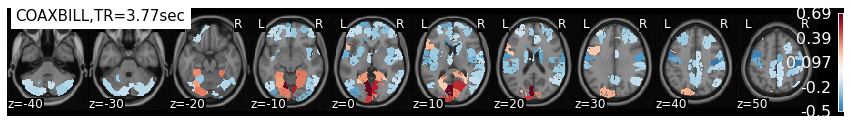

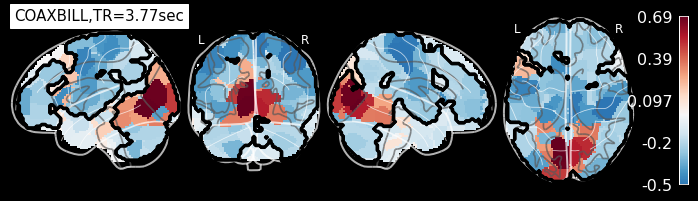

In [377]:
txt = f"COAXBILL,TR={3.77}sec"
nodes = np.zeros((268,))
nodes[pcoaxbill] = mean_diff_decpt[pcoaxbill]
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
img = roi_to_brain(pd.Series(mean_diff_decpt), mask_x)
glassb = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r',colorbar=True)
glassb.add_contours(color_rois(pcoaxbill),linewidths=2, colors='k',linestyles='solid')
#glassb.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=2, colors='m',linestyles='dashed')

img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))

In [378]:
len(np.where(pcoaxbill)[0])

104

In [319]:
len(np.where(nodes_coaxbill_rand_all & pcoaxbill)[0])

22

### Pre-decision AUC


In [376]:
# coax vs. bill

pcoaxbill_pre = np.empty((268,))
pcoaxbill_pre[:] = np.nan
mean_diff_aucs = np.empty_like(pcoaxbill_pre)
mean_diff_aucs[:] = np.nan

for n in range(268):
    tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]

    auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
    auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
    _,pcoaxbill_pre[n] = stats.ttest_rel(auc1,auc2,nan_policy='omit')
    mean_diff_aucs[n] = np.nanmean(auc1-auc2)

print('unc:',len(np.where(pcoaxbill_pre<.05)[0]))
print('unc:',len(np.where(pcoaxbill_pre<.001)[0]))
pcoaxbill_pre_corr = lsu(pcoaxbill_pre,q=.05) #fdr_correction(pval_slope_rand,.05)
nodes = np.where(pcoaxbill_pre_corr)[0]
print('corr:',len(nodes),'nodes')



unc: 40
unc: 6
corr: 6 nodes


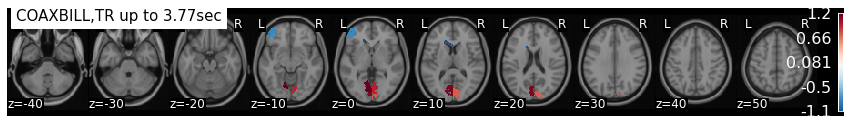

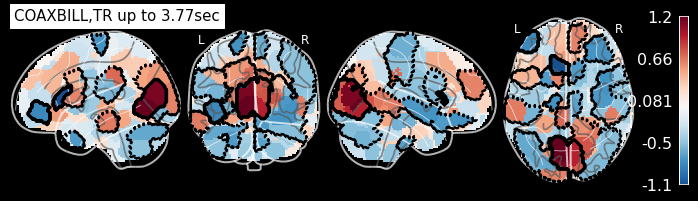

In [351]:
txt = f"COAXBILL,TR up to {3.77}sec"
nodes = np.zeros((268,))
nodes[pcoaxbill_pre_corr] = mean_diff_aucs[pcoaxbill_pre_corr]
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)

#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
img = roi_to_brain(pd.Series(mean_diff_aucs), mask_x)
glassb = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r',colorbar=True)
glassb.add_contours(color_rois(pcoaxbill_pre_corr),linewidths=2, colors='k',filled=False,linestyles='solid')
glassb.add_contours(color_rois(pcoaxbill_pre<.05),linewidths=2, colors='k',linestyles='dotted')
#glassb.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=2, colors='m',linestyles='dashed')

img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))

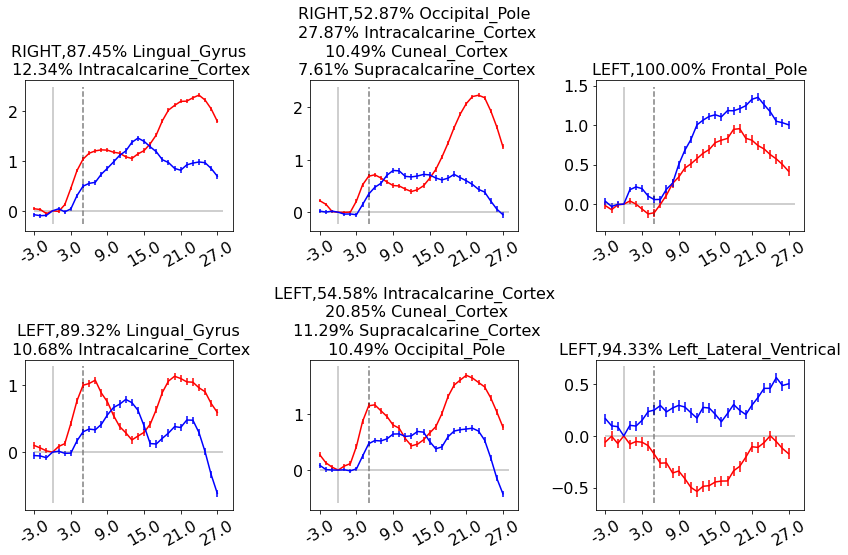

In [375]:
plt.figure(1,figsize=(12,8))
for i,n in enumerate(np.where(pcoaxbill_pre_corr)[0]): # nodes showing diffs between coax and bill
    plt.subplot(2,3,i+1)
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    plt.errorbar(range(tc1.shape[2]),np.nanmean(tc1[:,n,:],axis=0),stats.sem(tc1[:,n,:],axis=0),color='r')
    plt.errorbar(range(tc2.shape[2]),np.nanmean(tc2[:,n,:],axis=0),stats.sem(tc2[:,n,:],axis=0),color='b')
    plt.xticks(np.linspace(0,30,6),np.linspace(-3,27,6),rotation=30)
    ymin,ymax = plt.ylim()
    plt.vlines(tr0_ind+tr_dec,ymin,ymax,color='k',alpha=.5, ls='dashed')
    plt.vlines(tr0_ind,ymin,ymax,color='grey',alpha=.5)
    plt.hlines(0,0,31,color='grey',alpha=.5)                     

    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    roi = '\n'.join(roi)
    
    pref = 'LEFT' if n+1>134 else 'RIGHT'
                                        
    #if mean_diff[n]>0:
    plt.title(pref + ',' + roi)               
    '''if mean_diff[n]>0:
        plt.title(f'node{str(n+1)},\nsldiff={mean_diff[n]:.2f}',color = 'r')
    else:
        plt.title(f'node{str(n+1)},\nsldiff={mean_diff[n]:.2f}',color = 'b')'''
plt.tight_layout()



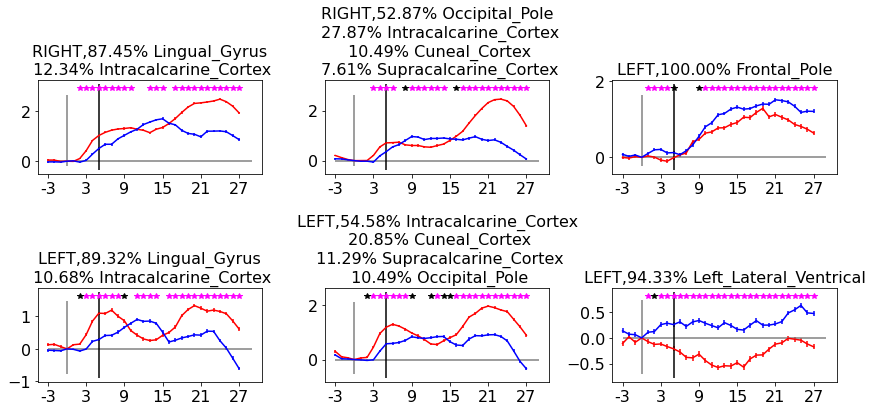

In [372]:
plt.figure(1,figsize=(12,6))
for i,n in enumerate(np.where(pcoaxbill_pre_corr)[0]): # nodes showing diffs between coax and bill
    plt.subplot(2,3,i+1)
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                        tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
    ymin,ymax = plt.ylim()
    plt.vlines(tr0_ind+tr_dec,ymin,ymax,color='k')
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    roi = '\n'.join(roi)
    
    pref = 'LEFT' if n+1>134 else 'RIGHT'
                                        
    #if mean_diff[n]>0:
    plt.title(pref + ',' + roi)
    #else:
    #    plt.title(f'node{str(n+1)})
plt.tight_layout()



In [340]:
for n in np.where(pcoaxbill_pre)[0]:
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    print(roi)


['87.45% Lingual_Gyrus', ' 12.34% Intracalcarine_Cortex']
['52.87% Occipital_Pole', ' 27.87% Intracalcarine_Cortex', ' 10.49% Cuneal_Cortex', ' 7.61% Supracalcarine_Cortex']
['100.00% Frontal_Pole']
['89.32% Lingual_Gyrus', ' 10.68% Intracalcarine_Cortex']
['54.58% Intracalcarine_Cortex', ' 20.85% Cuneal_Cortex', ' 11.29% Supracalcarine_Cortex', ' 10.49% Occipital_Pole']
['94.33% Left_Lateral_Ventrical']


## Sanity checks by plotting timecourses w reg coeffts to understand results better

In [321]:
coax = np.load(os.path.join(data_file_loc,'coef_slopereg_trialnorm_COAXING-B.npy'))
bill = np.load(os.path.join(data_file_loc,'coef_slopereg_trialnorm_BILLIARD-A.npy'))
coax.shape

mean_diff =  np.nanmean(coax-bill,axis=0)
for n in range(268):
    t,p = stats.ttest_rel(coax[:,n],bill[:,n])
    if p>.05:
        mean_diff[n] = np.nan


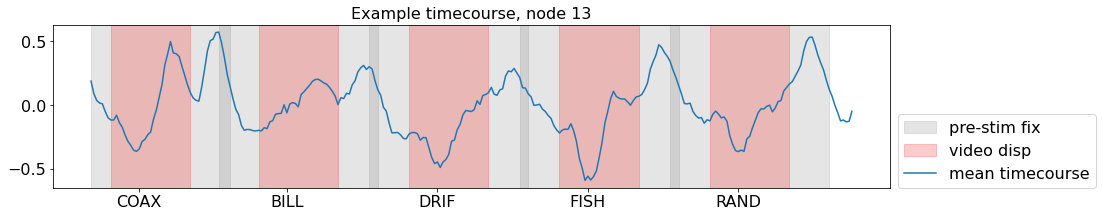

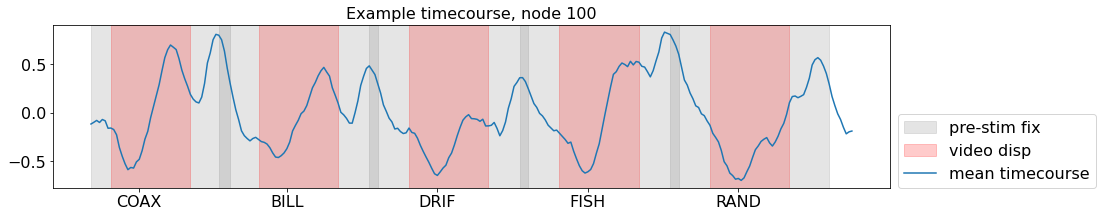

In [322]:
timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses.shape

plt.figure(1,figsize=(15,3))
node = 13
plt.title(f'Example timecourse, node {node}')
plt.errorbar(range(269),np.nanmean(timecourses[:,node-1,:,0],axis=0),label = 'mean timecourse')

for i in range(5):
    if i == 0:
        plt.axvspan(timepts_indiv_movie[i][0],                    timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28+14,alpha = .2, 
        color = 'grey', label = 'pre-stim fix')
        plt.axvspan(timepts_indiv_movie[i][0]+vid_start_rel_tr[i],timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28,alpha = .2, 
        color = 'r', label = 'video disp')
    else:
        plt.axvspan(timepts_indiv_movie[i][0],                    timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28+14,alpha = .2, 
        color = 'grey')
        plt.axvspan(timepts_indiv_movie[i][0]+vid_start_rel_tr[i],timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28,alpha = .2, 
        color = 'r')
    #plt.axvspan(timepts_indiv_movie[i][0],timepts_indiv_movie[i][-1],alpha = .2)

    #y1 = np.repeat(timepts_indiv_movie[i][0],5)
    #plt.vlines(timepts_indiv_movie[i][0],-.5,.5,color = 'r')
    #plt.vlines(timepts_indiv_movie[i][0]+28,-.5,.5,color = 'r')
plt.xticks([t[vid_start_rel_tr[i]]+10 for i,t in enumerate(timepts_indiv_movie[:5])],[str.upper(i[:4]) for i in vidnames[:5]])
plt.legend(bbox_to_anchor=(1,.5))


plt.figure(2,figsize=(15,3))
node = 100
plt.title(f'Example timecourse, node {node}')
plt.errorbar(range(269),np.nanmean(timecourses[:,node-1,:,0],axis=0),label = 'mean timecourse')

for i in range(5):
    if i == 0:
        plt.axvspan(timepts_indiv_movie[i][0],                    timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28+14,alpha = .2, 
        color = 'grey', label = 'pre-stim fix')
        plt.axvspan(timepts_indiv_movie[i][0]+vid_start_rel_tr[i],timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28,alpha = .2, 
        color = 'r', label = 'video disp')
    else:
        plt.axvspan(timepts_indiv_movie[i][0],                    timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28+14,alpha = .2, 
        color = 'grey')
        plt.axvspan(timepts_indiv_movie[i][0]+vid_start_rel_tr[i],timepts_indiv_movie[i][0]+ vid_start_rel_tr[i]+28,alpha = .2, 
        color = 'r')
    #plt.axvspan(timepts_indiv_movie[i][0],timepts_indiv_movie[i][-1],alpha = .2)

    #y1 = np.repeat(timepts_indiv_movie[i][0],5)
    #plt.vlines(timepts_indiv_movie[i][0],-.5,.5,color = 'r')
    #plt.vlines(timepts_indiv_movie[i][0]+28,-.5,.5,color = 'r')
plt.xticks([t[vid_start_rel_tr[i]]+10 for i,t in enumerate(timepts_indiv_movie[:5])],[str.upper(i[:4]) for i in vidnames[:5]])
plt.legend(bbox_to_anchor=(1,.5))

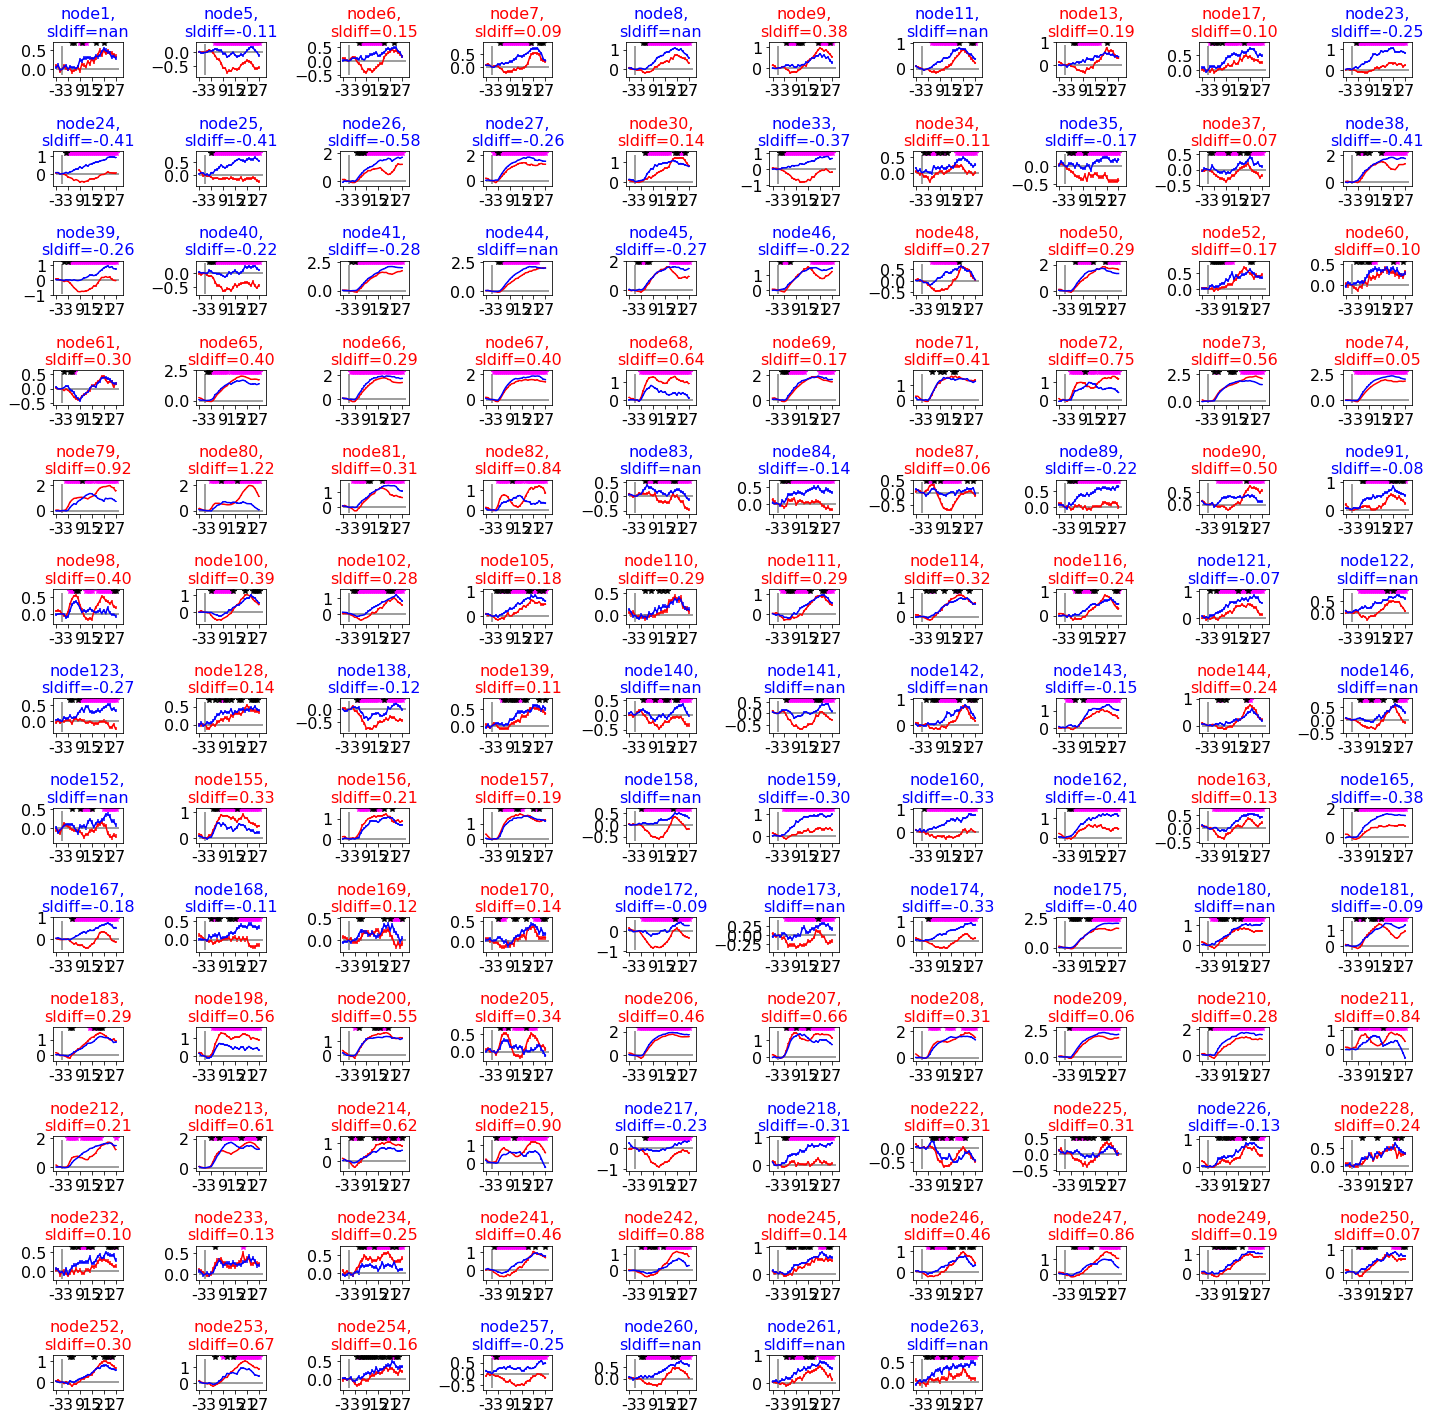

In [71]:
plt.figure(1,figsize=(20,20))
for i,n in enumerate(nodes_all[0]): # nodes showing diffs between coax and bill
    plt.subplot(13,10,i+1)
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                        tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
                                        
    if mean_diff[n]>0:
        plt.title(f'node{str(n+1)},\nsldiff={mean_diff[n]:.2f}',color = 'r')
    else:
        plt.title(f'node{str(n+1)},\nsldiff={mean_diff[n]:.2f}',color = 'b')
plt.tight_layout()


- about 75 out of 110 movies show a negative value for activity. Looks like the inclusion of the fixation in the regression analysis helps, and it's not the overall normalization that includes the pre/post stim period (if it were so, even these timecourses would look positive)
- best thing to do acc to me - focus on the magnitude of diff, ignore the direction

### Plot an ROI's timecourse


In [ ]:
# plot a region's timcourses in each analysis

n = 136
nodes = np.empty((268,))
nodes[:] = np.nan
nodes[n] = 1
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f"yes-no,TR={tr_dec},{lbl}"
img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

plt.figure(3,figsize = (10,3))
roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
title_str = 'Node '+ str(n+1) + ',' + ','.join(roi)
plt.suptitle(title_str,fontsize = 10,fontweight = 'bold')
   

for compType,lbl in enumerate(['coaxbill','rand','allmatched']):
    
    plt.subplot(1,nComps,compType+1)

    if compType == 0:
        tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,:,movie_ind_no]
        tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
                                            tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
        

    elif compType == 1:
        tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
        tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same],axis=0)-\
                                    np.nanmean(tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same],axis=0)
    
    elif compType == 2:
        tc1 = tcs_trial_resh_yes_matched
        tc2 = tcs_trial_resh_no_matched
        tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
        mean_diff_decpt = np.nanmean(tc1[:,:,tr0_ind+tr_dec],axis=0)-\
                                    np.nanmean(tc2[:,:,tr0_ind+tr_dec],axis=0)
    
    plt.title(f'Mean diff = {str(np.round(mean_diff_decpt[n],2))},{lbl}',fontsize = 12)
     
    #print(n+1,roi)
    ymin,ymax =plt.ylim()
    plt.vlines(tr_dec+tr0_ind,ymin,ymax,color = 'magenta')
    if compType==2:
        plt.tight_layout()

Node: 10 , 48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus
Node: 54 , 44.25% Middle_Temporal_Gyrus_posterior_division; 31.27% Superior_Temporal_Gyrus_posterior_division; 19.17% Middle_Temporal_Gyrus_temporooccipital_part; 5.01% Supramarginal_Gyrus_posterior_division
Node: 68 , 45.02% Lingual_Gyrus; 42.60% Temporal_Occipital_Fusiform_Cortex; 6.43% Parahippocampal_Gyrus_posterior_division; 5.63% Temporal_Fusiform_Cortex_posterior_division
Node: 73 , 76.60% Lateral_Occipital_Cortex_superior_division; 17.79% Occipital_Pole; 5.61% Lateral_Occipital_Cortex_inferior_division
Node: 79 , 87.45% Lingual_Gyrus; 12.34% Intracalcarine_Cortex
Node: 80 , 52.87% Occipital_Pole; 27.87% Intracalcarine_Cortex; 10.49% Cuneal_Cortex; 7.61% Supracalcarine_Cortex
Node: 82 , 79.23% Intracalcarine_Cortex; 14.00% Lingual_Gyrus
Node: 87 , 49.82% Right_Lateral_Ventricle; 19.78% Precuneous_Cortex; 17.22% Lingual_Gyrus; 11.72% Intracalcarine_Cortex
Node: 98 , 37.08% Cingulate_Gyrus_po

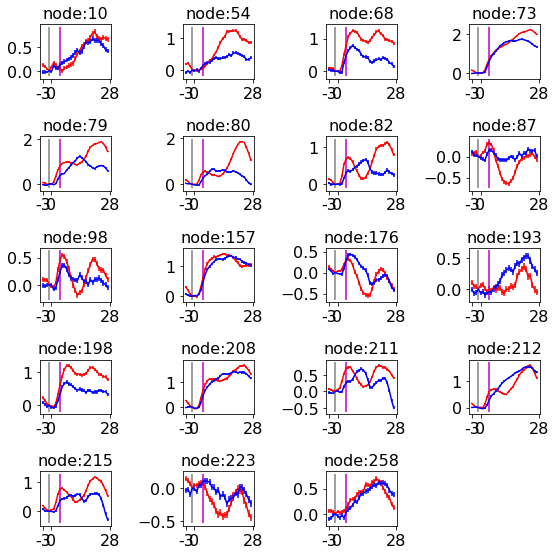

In [194]:
count= 0
for n in np.where(nodes_all_pre[0])[0]:
    if np.round(mean_diff_aucs[n,0],2) > 0:
        count+=1
        print('Node:',n+1,',',eval(shen268[str(n+1)][0])['name'])
print(count)

i=0
plt.figure(1,figsize=(8,8))
for n in np.where(nodes_all_pre[0])[0]:
    if np.round(mean_diff_aucs[n,0],2) > 0:
        i += 1
        plt.subplot(5,4,i)
        plt.title(f'node:{n+1}')
        tc1 = tcs_trial_z[:,n,:,0]
        tc2 = tcs_trial_z[:,n,:,1]
        plt.errorbar(range(31),np.nanmean(tc1,axis=0),stats.sem(tc1,axis=0),color='r')
        plt.errorbar(range(31),np.nanmean(tc2,axis=0),stats.sem(tc2,axis=0),color ='b')
        plt.xticks([0,4,31],['-3','0','28'])
        ymin,ymax = plt.ylim()
        plt.vlines(3,ymin,ymax,color='grey')
        plt.vlines(8,ymin,ymax,color='m')
        
plt.tight_layout()



In [176]:
for n in np.where(nodes_all_pre[0])[0]:
    if np.round(mean_diff_aucs[n,0],2) < 0:
        print('Node:',n+1,',',eval(shen268[str(n+1)][0])['name'])

Node: 2 , 60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex
Node: 17 , 66.67% Frontal_Pole; 32.63% Frontal_Orbital_Cortex
Node: 21 , 63.51% Precentral_Gyrus; 33.67% Inferior_Frontal_Gyrus_pars_opercularis
Node: 23 , 59.68% Postcentral_Gyrus; 36.99% Precentral_Gyrus
Node: 24 , 75.89% Precentral_Gyrus; 11.78% Postcentral_Gyrus; 8.22% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)
Node: 33 , 79.75% Postcentral_Gyrus; 20.25% Precentral_Gyrus
Node: 34 , 72.35% Insular_Cortex; 17.49% Planum_Polare
Node: 37 , 43.19% Insular_Cortex; 26.90% Right_Putamen; 17.88% Planum_Polare; 11.15% Heschl's_Gyrus_(includes_H1_and_H2)
Node: 45 , 56.46% Supramarginal_Gyrus_anterior_division; 29.54% Postcentral_Gyrus; 10.47% Supramarginal_Gyrus_posterior_division
Node: 66 , 35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus
Node: 67 , 54.07% Occipital_Fusifor

In [149]:
np.where(nodes_all_pre[0]&nodes_all_pre[1])[0]

array([ 81, 214])

In [160]:
nodes_coaxbill_all

array([130, 179, 209])

In [158]:
nodes_coaxbill_rand = np.where(nodes_all_pre[0]&nodes_all_pre[1])[0]
nodes_coaxbill_all = np.where(nodes_all_pre[0]&nodes_all_pre[2])[0]

0.15529395887599215 0.010901144910920393
 
0.2109 x + 0.1493
0.29561455391625774 8.334771298965142e-07
 
0.1676 x - 0.06164


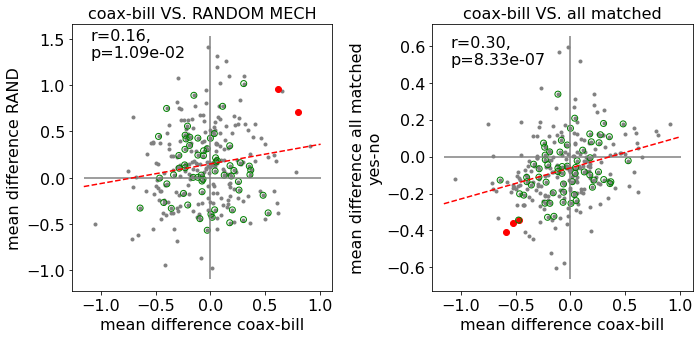

In [170]:
plt.figure(1,figsize=(10,5)) # coaxbill vs. rand
plt.subplot(1,2,1)
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,1],color='grey',marker='.')
plt.scatter(mean_diff_aucs[nodes_coaxbill_rand,0],mean_diff_aucs[nodes_coaxbill_rand,1],marker = 'o',facecolors = 'r', edgecolors ='r')
plt.scatter(mean_diff_aucs[nodes_coaxbill_rand_all,0],mean_diff_aucs[nodes_coaxbill_rand_all,1],marker = 'o',facecolors = 'none', edgecolors ='g')
r,p = stats.pearsonr(mean_diff_aucs[:,0],mean_diff_aucs[:,1])
print(r,p)
plt.title('coax-bill VS. RANDOM MECH')
ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
m, b = np.polyfit(mean_diff_aucs[:,0],mean_diff_aucs[:,1], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.text(-1.1,1.3,f'r={r:.2f},\np={p:.2e}')

plt.xlabel('mean difference coax-bill')
plt.ylabel('mean difference RAND')

plt.subplot(1,2,2) # coaxbill vs. all matched
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,2],color='grey',marker='.')
plt.scatter(mean_diff_aucs[nodes_coaxbill_all,0],mean_diff_aucs[nodes_coaxbill_all,2],marker = 'o',facecolors = 'r', edgecolors ='r')
plt.scatter(mean_diff_aucs[nodes_coaxbill_rand_all,0],mean_diff_aucs[nodes_coaxbill_rand_all,2],marker = 'o',facecolors = 'none', edgecolors ='g')
r,p=stats.pearsonr(mean_diff_aucs[:,0],mean_diff_aucs[:,2])
print(r,p)
ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()
plt.title('coax-bill VS. all matched')
plt.xlabel('mean difference coax-bill')
plt.ylabel('mean difference all matched\nyes-no')
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
m, b = np.polyfit(mean_diff_aucs[:,0],mean_diff_aucs[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.text(-1.1,.5,f'r={r:.2f},\np={p:.2e}')

plt.tight_layout()

In [ ]:
plt.figure(1,figsize=(10,5))

plt.subplot(121)
plt.scatter(mean_diff_aucs[:,0],mean_diff_all_during[:,0])
print("coax-bill:",stats.spearmanr(mean_diff_aucs[:,0],mean_diff_all_during[:,0],nan_policy='omit'))
m, b = np.polyfit(mean_diff_aucs[~np.isnan(mean_diff_aucs[:,0]),0],mean_diff_all_during[~np.isnan(mean_diff_aucs[:,0]),0], 1)
print(np.poly1d([m,b]))
xmin,xmax = plt.xlim()
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.xlabel('coax-bill up to TR=4')
plt.ylabel('coax-bill during')

plt.subplot(122)
plt.scatter(mean_diff_aucs[:,1],mean_diff_all_during[:,1])
print("rand:",stats.spearmanr(mean_diff_aucs[:,1],mean_diff_all_during[:,1],nan_policy='omit'))
m, b = np.polyfit(mean_diff_aucs[~np.isnan(mean_diff_aucs[:,1]),1],mean_diff_all_during[~np.isnan(mean_diff_aucs[:,0]),1], 1)
print(np.poly1d([m,b]))
xmin,xmax = plt.xlim()
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.xlabel('rand yes-no up to TR=4')
plt.ylabel('rand yes-no during')

plt.tight_layout()

- The analysis above shows that the nodes which showed a higher yes-no difference before also shows the difference during  (at TR=4) - so the differences at TR=4 for is a reasonable indicator of nodes involved in early decision-making. This could be useful because we see below that correlating pre yes-no between analyses isn't significant, and few regions show the difference (is this correct? check again!)


SpearmanrResult(correlation=0.15538055696334127, pvalue=0.019431820289590493)
SpearmanrResult(correlation=0.3298434109131548, pvalue=3.8984797856858917e-07)


SpearmanrResult(correlation=0.5008206587153956, pvalue=0.0013623359288334551)

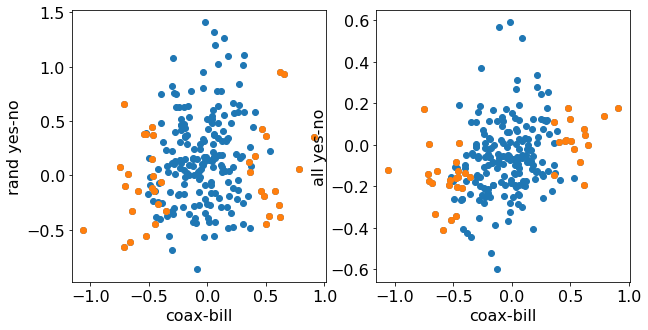

In [100]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,1])
print(stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs[:,1],nan_policy='omit'))
plt.xlabel('coax-bill')
plt.ylabel('rand yes-no')

plt.scatter(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,1])
stats.spearmanr(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,1],nan_policy='omit')

plt.subplot(122)
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs[:,2])
print(stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs[:,2],nan_policy='omit'))
plt.xlabel('coax-bill')
plt.ylabel('all yes-no')

plt.scatter(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,2])
stats.spearmanr(mean_diff_aucs[nodes,0],mean_diff_aucs[nodes,2],nan_policy='omit')

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
sig nodes: 42
nr of nodes: 12


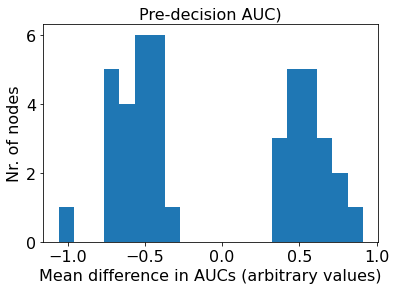

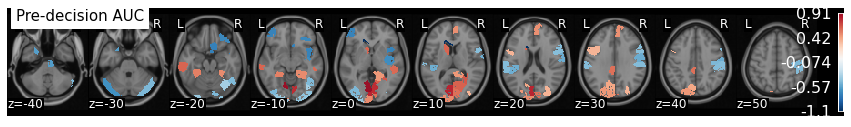

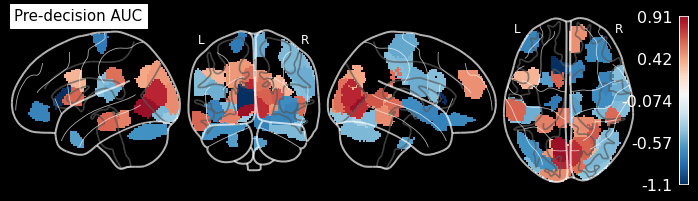

In [104]:
# pre-decision AUC
#DIFF MOVIES 
#mean_diff_all = []
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =5

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]
    auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
    auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
    mean_diff[n] = np.nanmean(auc1-auc2)
    _,p[n] = stats.ttest_rel(auc1,auc2)
    
mean_diff[p>.05] = np.nan  
print('sig nodes:',len(np.where(~np.isnan(mean_diff))[0]))

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')

img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,colorbar=True,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

nodes = np.where(np.abs(mean_diff)>.6*np.nanmax(np.abs(mean_diff)))[0]
print('nr of nodes:',len(nodes))

#mean_diff_all.append(['diff',mean_diff])


## timecourses correlation

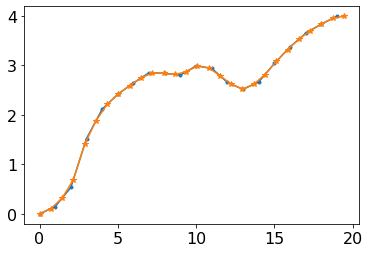

In [89]:
# contrater
tc_diff = np.load(os.path.join(data_file_loc,'coax_bill_contrater.npy'))
tc_diff.shape
tr = .72
x = np.arange(0,20) # timepoints in secs
xvals = [i/100 for i in range(0,10000) if i%(100*tr)==0]
xvals = xvals[:28]    
tc_diff_interp = np.interp(xvals, x, tc_diff)
plt.plot(range(len(tc_diff)),tc_diff,marker = '.')
plt.plot(xvals,tc_diff_interp,marker = '*')

In [90]:
# mean diffs
tc_diff_fmri = np.empty((268,28))
tc_diff_fmri[:] = np.nan
corr_diffs = np.empty((tcs_trial_z.shape[0],268))
corr_diffs[:] = np.nan

#for compType,lbl in enumerate(['diff','same','all','allSame']):

for n in range(268):
    tc_diff_fmri = tcs_trial_z[:,n,tr0_ind:,0]-tcs_trial_z[:,n,tr0_ind:,1]
    #mean_diffs[n,:] = np.nanmean(tcs_trial_z[:,n,tr0_ind:,0]-tcs_trial_z[:,n,tr0_ind:,1],axis=0)
    for s in range(tcs_trial_z.shape[0]):
        corr_diffs[s,n],_ = stats.pearsonr(tc_diff_interp[:tr_dec+2],tc_diff_fmri[s,:tr_dec+2])
        #if p < .05:
        #corr_diffs[s,n] = r

#corr_diffs

sig nodes:  161


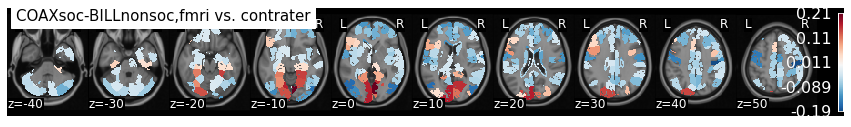

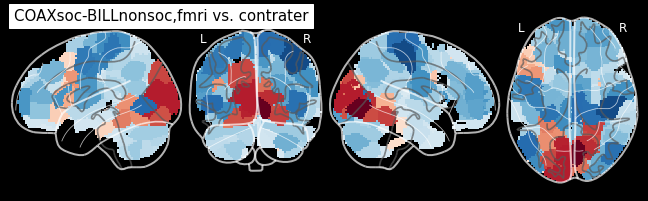

In [91]:
mean_corr = np.nanmean(corr_diffs,axis=0)
for n in range(268):
    _,p = stats.ttest_1samp(corr_diffs[:,n],0,nan_policy='omit')
    if p > .05:
        mean_corr[n]= np.nan
        
sig_nodes = np.where(~np.isnan(mean_corr))[0]
print('sig nodes: ',len(sig_nodes))
img = roi_to_brain(pd.Series(mean_corr), mask_x)
txt = f"COAXsoc-BILLnonsoc,fmri vs. contrater"
img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



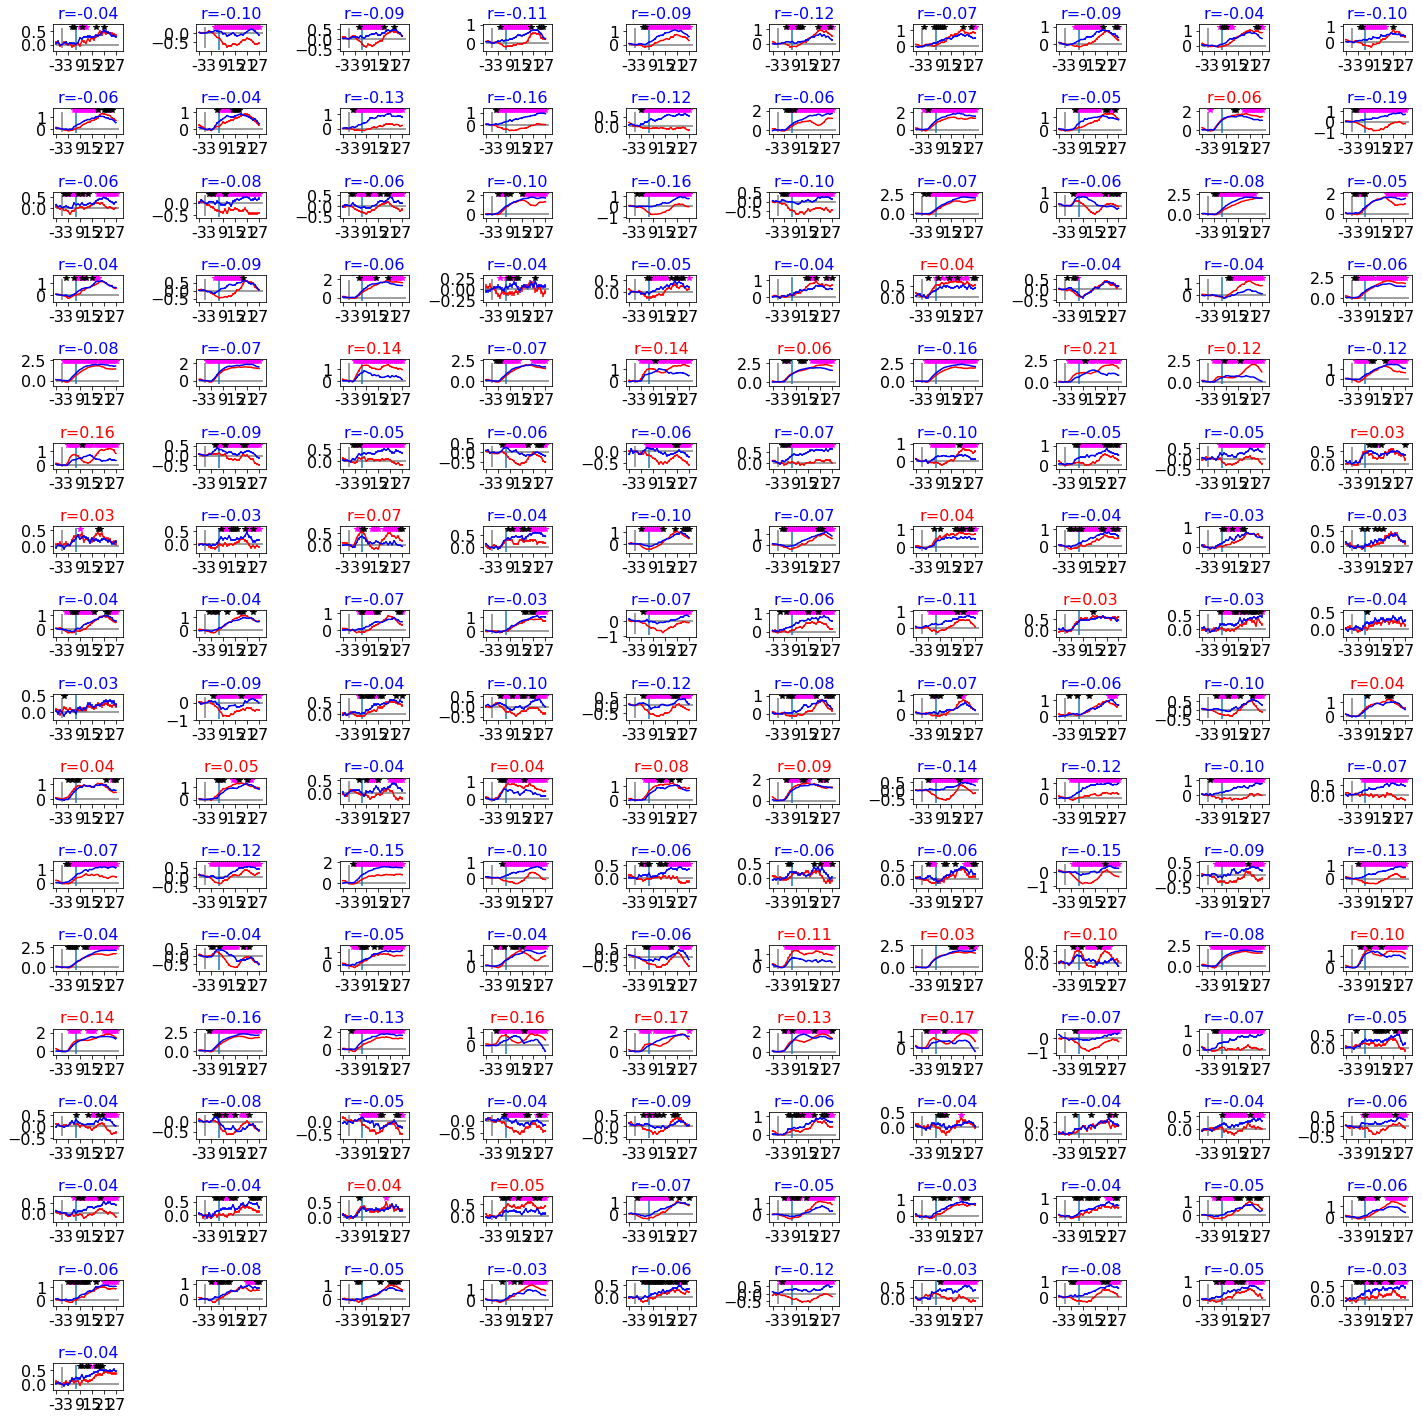

In [97]:
plt.figure(1,figsize=(20,20))
for i,n in enumerate(sig_nodes):
    plt.subplot(17,10,i+1)
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    #tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'diff',0,tr0_ind)
    ymin,ymax = plt.ylim()
    plt.vlines(tr0_ind+tr_dec+2,ymin,ymax)
    if mean_corr[n] > 0:
        plt.title(f'r={mean_corr[n]:.2f}',color = 'r')
    else:
        plt.title(f'r={mean_corr[n]:.2f}',color='b')
    #mean_diff_decpt = np.nanmean(tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]-
    #                                    tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_no],axis =0)
plt.tight_layout()


Text(0, 0.5, 'corr w/ contrater')

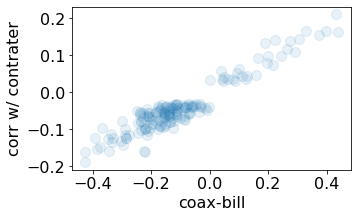

In [103]:
plt.figure(1,figsize=(5,3))
plt.scatter(mean_diff_all_during[:,0],mean_corr,marker='o',s=100,alpha=0.1)
plt.xlabel('coax-bill')
plt.ylabel('corr w/ contrater')


In [25]:
df = pd.DataFrame({'meanDiff':abs(mean_diff),'lbl':[eval(shen268[str(n+1)][0])['name'] for n in range(268)]})
df['hem'] = 'left'
df.iloc[:134,2] = 'right'
df = df.sort_values(by='meanDiff',ascending=False)
df.head(40)


meanDiff  \
136  0.936026   
50   0.647461   
211  0.639370   
216  0.620397   
120  0.591026   
14   0.590253   
141  0.572200   
79   0.538417   
51   0.516873   
82   0.515316   
207  0.488415   
19   0.468433   
69   0.461668   
5    0.436613   
139  0.430185   
144  0.394944   
99   0.355296   
205  0.311931   
72   0.311869   
77   0.310607   
0         NaN   
1         NaN   
2         NaN   
3         NaN   
4         NaN   
6         NaN   
7         NaN   
8         NaN   
9         NaN   
10        NaN   
11        NaN   
12        NaN   
13        NaN   
15        NaN   
16        NaN   
17        NaN   
18        NaN   
20        NaN   
21        NaN   
22        NaN   

                                                                                                                                                                                                              lbl  \
136                                                                                                    52.38% Frontal_Medial_Cortex; 27.72% Frontal_Pole; 12.59% Frontal_Orbital_Cortex; 7.31% Subcallosal_Cortex   
50                                                                                                                                                                                           99.23% Temporal_Pole   
211                                                                                                                                                                                         99.66% Occipital_Pole   
216                                                                                                                                                                65.54% Left_Lateral_Ventrical; 33.78% no_label   
120                                                                                                                                                          72.15% Right_Caudate; 26.16% Right_Lateral_Ventricle   
14                                                                                                                                           58.36% Cingulate_Gyrus_anterior_division; 41.00% Paracingulate_Gyrus   
141                                                                                                                                                                                          100.00% Frontal_Pole   
79                                                                                                         52.87% Occipital_Pole; 27.87% Intracalcarine_Cortex; 10.49% Cuneal_Cortex; 7.61% Supracalcarine_Cortex   
51                                                                                                                                                                                           99.80% Temporal_Pole   
82                                                                                                                                           72.92% Cingulate_Gyrus_anterior_division; 26.74% Paracingulate_Gyrus   
207                                                                                                                54.10% Lateral_Occipital_Cortex_superior_division; 24.75% Occipital_Pole; 19.98% Cuneal_Cortex   
19                           43.55% Frontal_Operculum_Cortex; 33.40% Insular_Cortex; 10.36% Inferior_Frontal_Gyrus_pars_triangularis; 6.98% Frontal_Orbital_Cortex; 5.71% Inferior_Frontal_Gyrus_pars_opercularis   
69   54.11% Inferior_Temporal_Gyrus_temporooccipital_part; 17.25% Middle_Temporal_Gyrus_temporooccipital_part; 14.99% Middle_Temporal_Gyrus_posterior_division; 13.55% Inferior_Temporal_Gyrus_posterior_division   
5                                                                                                                                                                                            100.00% Frontal_Pole   
139                                                                                                             

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
sig nodes: 20
nr of nodes: 7


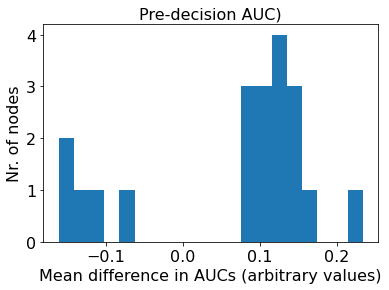

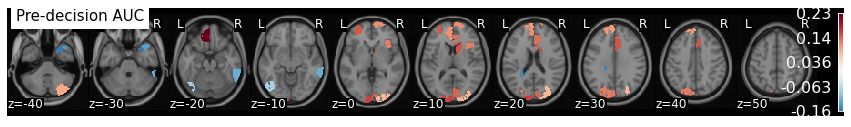

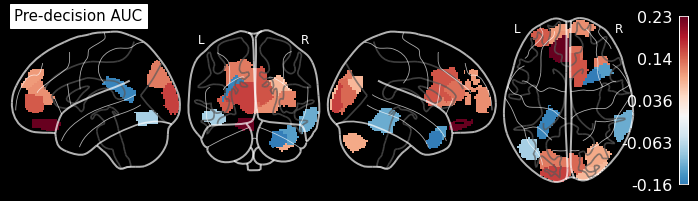

In [196]:
# pre-decision AUC
#DIFF MOVIES 
#mean_diff_all = []
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =5

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]
    auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
    auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
    mean_diff[n] = np.nanmean(auc1-auc2)
    _,p[n] = stats.ttest_rel(auc1,auc2)
    
mean_diff = mean_diff
mean_diff[p>.05] = np.nan  
print('sig nodes:',len(np.where(~np.isnan(mean_diff))[0]))

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')

img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,colorbar=True,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

nodes = np.where(np.abs(mean_diff)>.6*np.nanmax(np.abs(mean_diff)))[0]
print('nr of nodes:',len(nodes))

#mean_diff_all.append(['diff',mean_diff])


node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 14


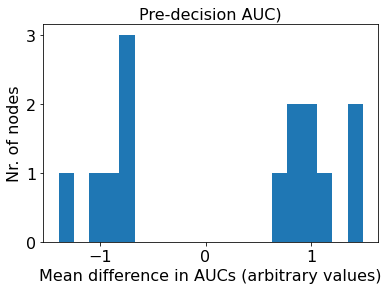

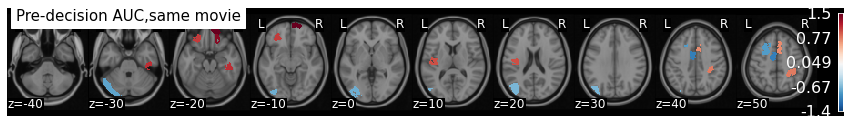

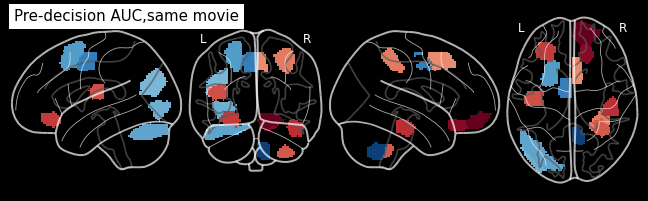

In [199]:
# pre-decision AUC
#SAME MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_run_z[subs1,n,:int(tr0_ind+tr_dec),movie_ind_same]
    tc2 = tcs_run_z[subs2,n,:int(tr0_ind+tr_dec),movie_ind_same]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff = mean_diff
mean_diff_all.append(['same',mean_diff])
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,same movie"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 14


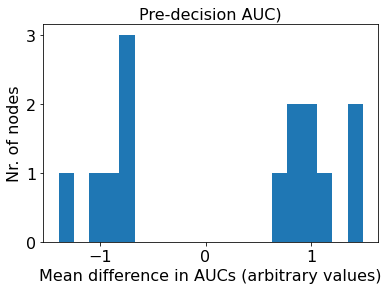

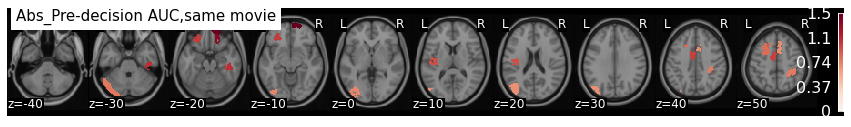

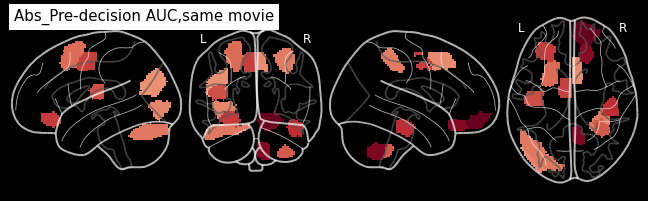

In [44]:
# pre-decision AUC
#SAME MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_run_z[subs1,n,:int(tr0_ind+tr_dec),movie_ind_same]
    tc2 = tcs_run_z[subs2,n,:int(tr0_ind+tr_dec),movie_ind_same]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff = mean_diff
#mean_diff_all.append(['same',mean_diff])
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(abs(mean_diff)), mask_x)
txt = f"Abs_Pre-decision AUC,same movie"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



In [45]:
df = pd.DataFrame({'meanDiff':abs(mean_diff),'lbl':[eval(shen268[str(n+1)][0])['name'] for n in range(268)]})
df['hem'] = 'left'
df.iloc[:134,2] = 'right'
df = df.sort_values(by='meanDiff',ascending=False)
df.head(20)


meanDiff  \
0    1.488323   
114  1.390269   
3    1.356801   
58   1.098655   
151  1.037565   
160  1.019519   
172  0.954011   
117  0.911166   
163  0.831085   
240  0.788464   
37   0.773944   
209  0.721371   
27   0.699092   
202  0.682031   
1         NaN   
2         NaN   
4         NaN   
5         NaN   
6         NaN   
7         NaN   

                                                                                                                                                                                lbl  \
0                                                                                                                                  92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex   
114                                                                                                                                              81.17% no_label; 18.83% Brain-Stem   
3                                                                                                                                54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex   
58                                                                            54.08% Inferior_Temporal_Gyrus_posterior_division; 45.92% Temporal_Fusiform_Cortex_posterior_division   
151                                                                                                                              54.11% Frontal_Orbital_Cortex; 45.89% Frontal_Pole   
160                                                            68.86% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 29.67% Cingulate_Gyrus_anterior_division   
172                                                                               59.09% Central_Opercular_Cortex; 31.36% Insular_Cortex; 9.55% Heschl's_Gyrus_(includes_H1_and_H2)   
117                                                                                                                                                                100.00% no_label   
163                                                                                                                      69.41% Superior_Frontal_Gyrus; 29.41% Middle_Frontal_Gyrus   
240                                                                             54.24% no_label; 20.68% Occipital_Fusiform_Gyrus; 18.34% Lateral_Occipital_Cortex_inferior_division   
37                                                                                                                        57.66% Superior_Parietal_Lobule; 36.57% Postcentral_Gyrus   
209                                                                        80.83% Lateral_Occipital_Cortex_inferior_division; 10.06% Occipital_Fusiform_Gyrus; 9.11% Occipital_Pole   
27   41.56% Paracingulate_Gyrus; 27.43% Superior_Frontal_Gyrus; 21.52% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 9.49% Cingulate_Gyrus_anterior_division   
202                                                                            86.31% Lateral_Occipital_Cortex_superior_division; 13.02% Lateral_Occipital_Cortex_inferior_division   
1                                                                                                                          60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex   
2                                                                                                                           58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex   
4                                                           47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole   
5                                                                                                                                                              100.00% Frontal_Pole   
6                                                                                                                                                              100.00% Fro

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 7


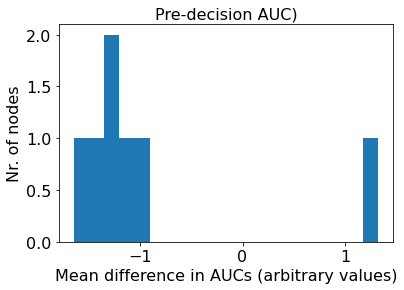

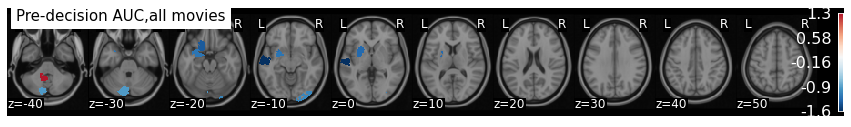

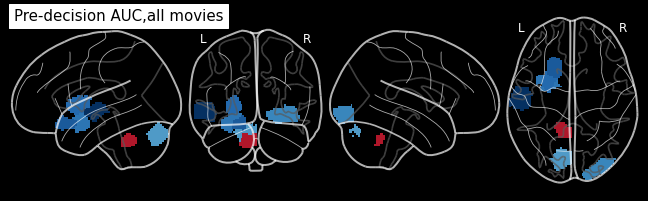

In [202]:
# pre-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes[subs1,n,:int(tr0_ind+tr_dec)]
    tc2 = tcs_trial_resh_no[subs2,n,:int(tr0_ind+tr_dec)]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)   
             
mean_diff_all.append(['all',mean_diff])
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')



In [209]:
inds = np.where(~np.isnan(mean_diff_all[0][1]))

In [212]:
mean_diff_all[1][0]

'same'

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 8


NameError: name 'mean_diff_all' is not defined

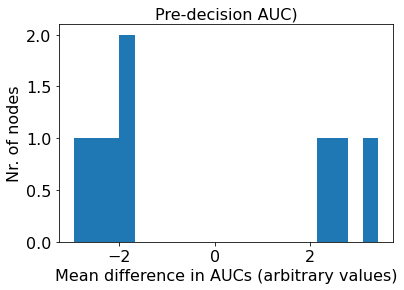

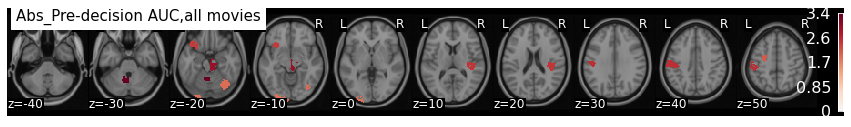

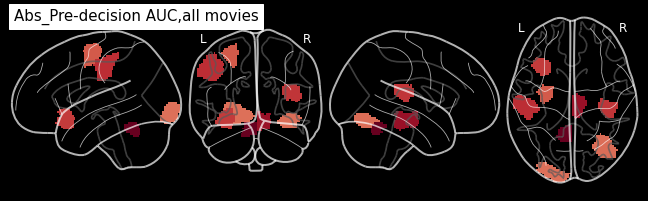

In [33]:
# pre-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes_matched[subs1,n,:int(tr0_ind+tr_dec)]
    tc2 = tcs_trial_resh_no_matched[subs2,n,:int(tr0_ind+tr_dec)]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(abs(mean_diff)), mask_x)
txt = f"Abs_Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

mean_diff_all.append(['all_matched',mean_diff])

In [34]:
df = pd.DataFrame({'meanDiff':abs(mean_diff),'lbl':[eval(shen268[str(n+1)][0])['name'] for n in range(268)]})
df['hem'] = 'left'
df.iloc[:134,2] = 'right'
df = df.sort_values(by='meanDiff',ascending=False)
df.head(40)


meanDiff  \
254  3.419183   
131  2.956124   
170  2.527561   
61   2.445403   
152  2.378786   
165  2.103257   
66   1.910157   
213  1.884146   
0         NaN   
1         NaN   
2         NaN   
3         NaN   
4         NaN   
5         NaN   
6         NaN   
7         NaN   
8         NaN   
9         NaN   
10        NaN   
11        NaN   
12        NaN   
13        NaN   
14        NaN   
15        NaN   
16        NaN   
17        NaN   
18        NaN   
19        NaN   
20        NaN   
21        NaN   
22        NaN   
23        NaN   
24        NaN   
25        NaN   
26        NaN   
27        NaN   
28        NaN   
29        NaN   
30        NaN   
31        NaN   

                                                                                                                                                                                      lbl  \
254                                                                                                                                                                       96.99% no_label   
131                                                                                                                                                    84.22% Brain-Stem; 14.85% no_label   
170                                                                                                                85.02% Postcentral_Gyrus; 14.98% Supramarginal_Gyrus_anterior_division   
61                                                           31.31% Parietal_Operculum_Cortex; 24.07% Planum_Temporale; 21.33% Heschl's_Gyrus_(includes_H1_and_H2); 21.33% Insular_Cortex   
152                                                                                                                                  78.97% Frontal_Orbital_Cortex; 18.35% Insular_Cortex   
165                                                                                                   67.49% Precentral_Gyrus; 17.83% Superior_Frontal_Gyrus; 14.67% Middle_Frontal_Gyrus   
66                                                          54.07% Occipital_Fusiform_Gyrus; 28.60% Lateral_Occipital_Cortex_inferior_division; 14.90% Temporal_Occipital_Fusiform_Cortex   
213                                                                                                               87.06% Occipital_Pole; 8.47% Lateral_Occipital_Cortex_inferior_division   
0                                                                                                                                        92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex   
1                                                                                                                                60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex   
2                                                                                                                                 58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex   
3                                                                                                                                      54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex   
4                                                                 47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole   
5                                                                                                                                                                    100.00% Frontal_Pole   
6                                                                                                                                                                    100.00% Frontal_Pole   
7                                                                                                                                                                     99.85% Frontal_Pole   
8                                                                                             

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 11


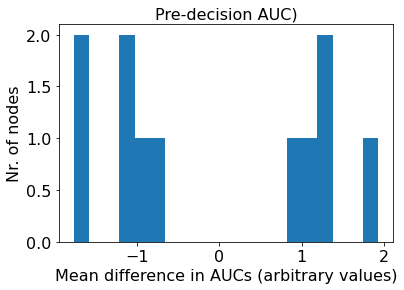

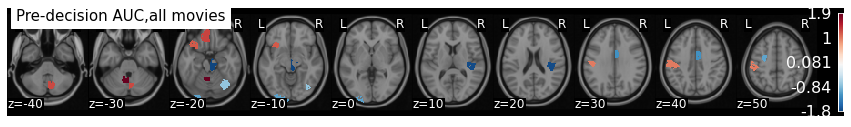

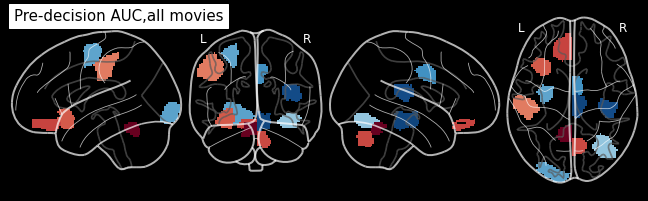

In [182]:
# pre-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes_matched[subs1,n,:int(tr0_ind+tr_dec)]
    tc2 = tcs_trial_resh_no_matched[subs2,n,:int(tr0_ind+tr_dec)]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Pre-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

mean_diff_all.append(['all_matched',mean_diff])

In [187]:
np.where(~np.isnan(mean_diff_all[1][1]))

(array([  0,   3,  27,  37,  58, 114, 117, 151, 160, 163, 172, 202, 209,
        240]),)

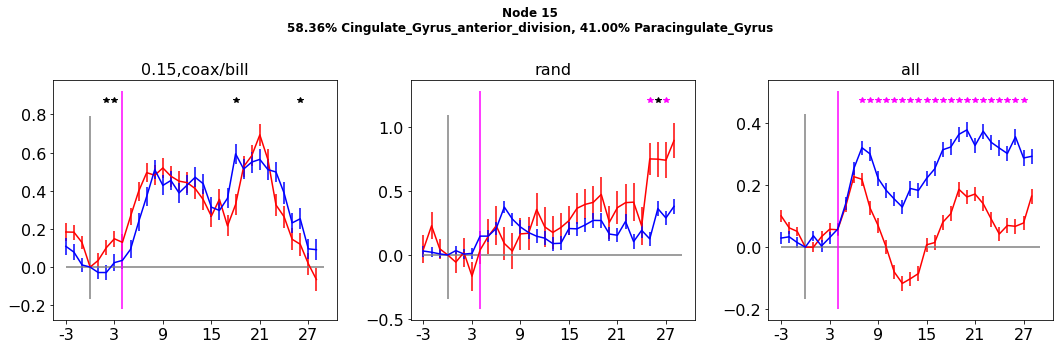

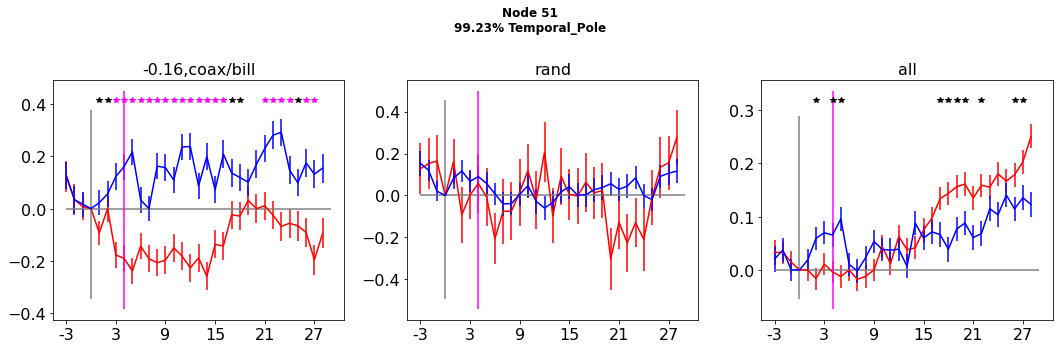

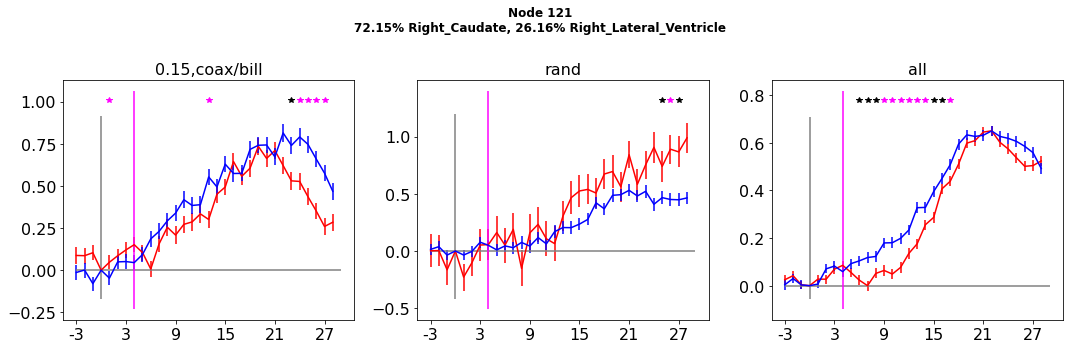

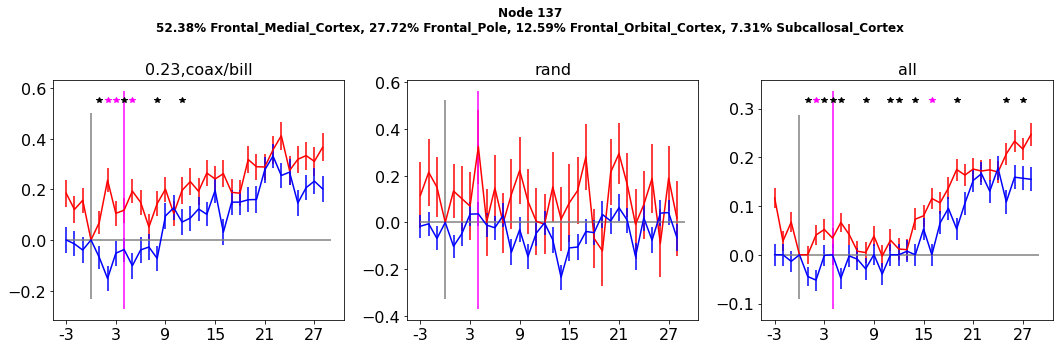

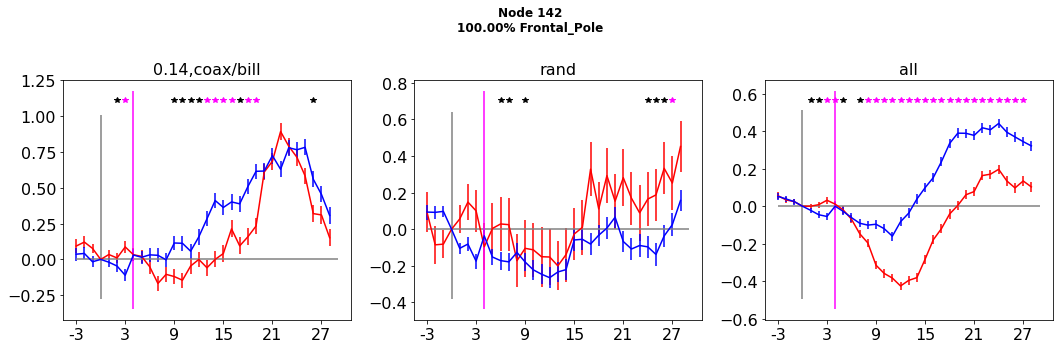

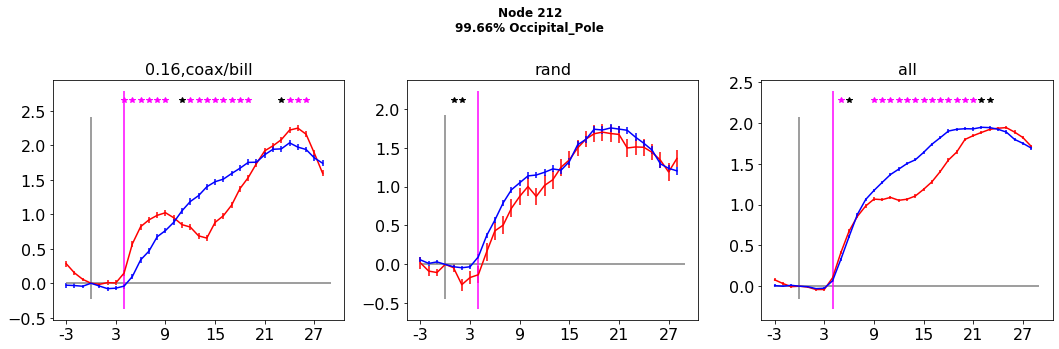

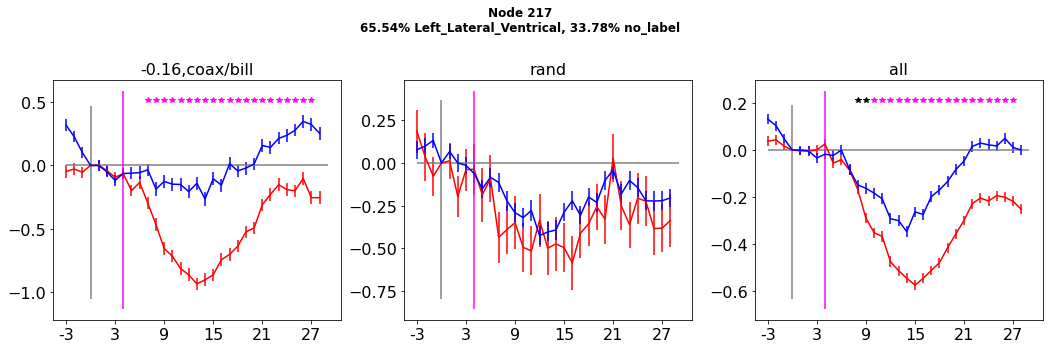

In [175]:
# plot same, diff and all movie timecourses for rois showing a difference in auc pre-decision
# to add in this, tc across all movies (yes vs. no)
# plotting timecourses of movies showing divergences at tr ~=3.5s
for i,n in enumerate(nodes):
    
    plt.figure(i,figsize = (15,5))
    
    #plt.title('Node '+ str(n+1))
    tc1 = tcs_trial_z[:,n,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,n,:,movie_ind_no]
    plt.subplot(1,3,1)
    tmt.ttest_diffmovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title(str(np.round(mean_diff[n],2)) + ',coax/bill')
    
    
    tc1 = tcs_run_z[subs1,n,:,movie_ind_same]
    tc2 = tcs_run_z[subs2,n,:,movie_ind_same]
    plt.subplot(1,3,2)
    tmt.ttest_samemovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('rand')
    
    tc1 = tcs_trial_resh_yes[:,n,:]
    tc2 = tcs_trial_resh_no[:,n,:]
    plt.subplot(1,3,3)
    tmt.ttest_samemovies(tc1,tc2,1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(4+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('all')
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    #print(n+1,roi)
    plt.suptitle('Node '+ str(n+1) + '\n' + ','.join(roi),
                 fontweight = 'bold',fontsize = 12)
    
    plt.tight_layout()

## post-decision AUCs

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 164


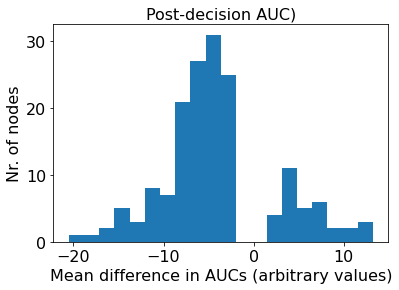

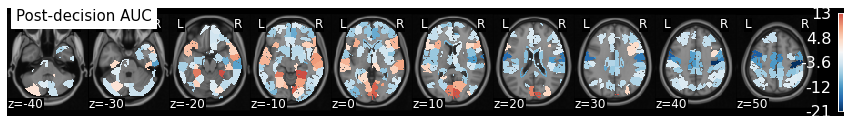

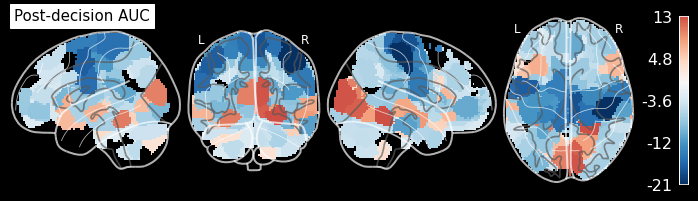

In [42]:
# post-decision AUC
#DIFF MOVIES 
mean_diff_aucs_post = np.empty((268,4))
mean_diff_aucs_post[:] = np.nan
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
tr_dec =5

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    diff_12 = (tcs_trial_z[:,n,int(tr0_ind+tr_dec):,movie_ind_yes]-\
                tcs_trial_z[:,n,int(tr0_ind+tr_dec):,movie_ind_no])
    auc1 = np.array([np.trapz(diff_12[s,:]) for s in range(tcs_trial_z.shape[0])])
    mean_diff[n] = np.nanmean(auc1)
    _,p[n] = stats.ttest_1samp(auc1,0)            

mean_diff_aucs_post[:,0] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Post-decision AUC"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,colorbar=True,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=0.24962354314738383, pvalue=7.058270551838594e-05)
during to post: SpearmanrResult(correlation=0.41676896001177016, pvalue=1.0999547753264844e-12)


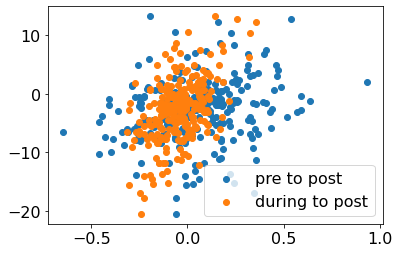

In [51]:
plt.scatter(mean_diff_aucs[:,0],mean_diff_aucs_post[:,0], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,0],mean_diff_aucs_post[:,0],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,0],mean_diff_aucs_post[:,0], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,0],mean_diff_aucs_post[:,0],nan_policy='omit'))

plt.legend()



In [ ]:


for i,n in enumerate(nodes):
    
    plt.figure(i,figsize = (10,5))
    
    #plt.title('Node '+ str(n+1))
    tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
    tc2 = tcs_trial_z[:,:,:,movie_ind_no]
    plt.subplot(1,2,1)
    tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(5+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title(str(np.round(mean_diff[n],2)) + ',coax/bill')
    
    
    tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
    tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
    plt.subplot(1,2,2)
    tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
    ymin,ymax =plt.ylim()
    plt.vlines(19+tr0_ind,ymin,ymax,color = 'magenta')
    plt.title('rand')
    
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    #print(n+1,roi)
    plt.suptitle('Node '+ str(n+1) + ',\n'+'\n'.join(roi),
                 fontweight = 'bold',fontsize = 12)
    
    plt.tight_layout()

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 62


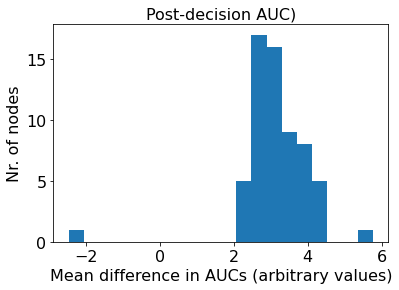

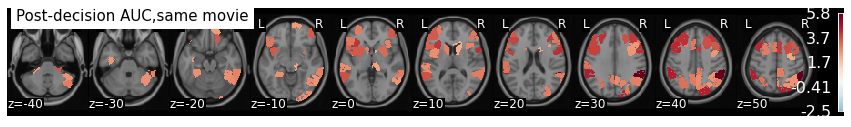

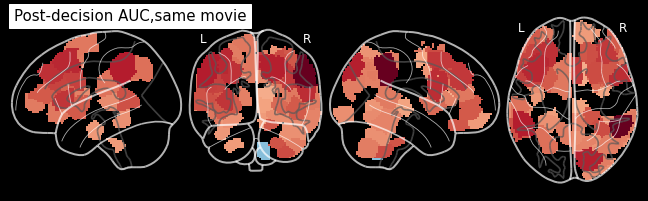

In [46]:
# post-decision AUC
#SAME MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
tr_dec =19 # later TR for decision

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_run_z[subs1,n,int(tr0_ind+tr_dec):,movie_ind_same]
    tc2 = tcs_run_z[subs2,n,int(tr0_ind+tr_dec):,movie_ind_same]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff_aucs_post[:,1] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   


plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Post-decision AUC,same movie"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=0.369938681197298, pvalue=1.8441840113085013e-09)
during to post: SpearmanrResult(correlation=0.3932097999622205, pvalue=2.4229290248875815e-11)


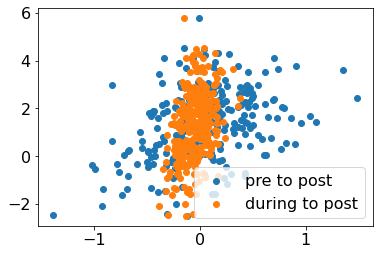

In [52]:
t = 1
plt.scatter(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.legend()



node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
nr of nodes: 94


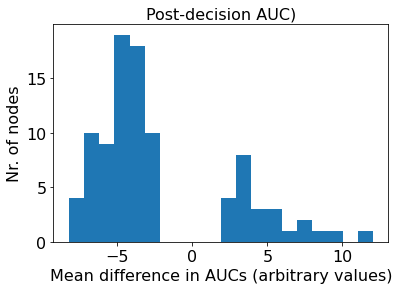

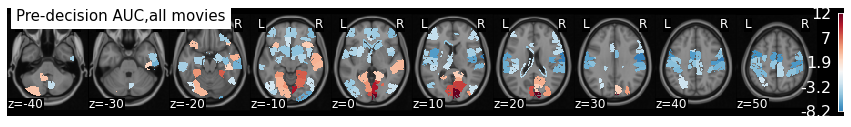

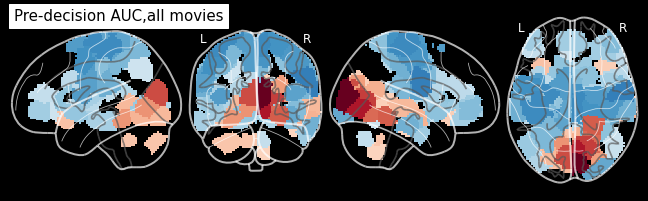

In [55]:
# post-decision AUC
#all MOVIES 
mean_diff = np.empty((268,))
mean_diff [:] = np.nan
p  = np.empty_like(mean_diff)
p[:] = np.nan
#tr_dec =8

for n in range(268):
    if n % 50 ==0:
        print('node:',n)
    
    tc1 = tcs_trial_resh_yes[subs1,n,int(tr0_ind+tr_dec):]
    tc2 = tcs_trial_resh_no[subs2,n,int(tr0_ind+tr_dec):]
    auc1 = [np.trapz(tc1[s,:]) for s in range(tc1.shape[0])]
    auc2 = [np.trapz(tc2[s,:]) for s in range(tc2.shape[0])]
    mean_diff[n] = np.nanmean(auc1)-np.nanmean(auc2)
    _,p[n] = stats.ttest_ind(auc1,auc2)            

mean_diff_aucs_post[:,2] = mean_diff
mean_diff[p>.05] = np.nan  
print('nr of nodes:',len(np.where(p<=.05)[0]))   

plt.hist(mean_diff,bins=20)
plt.xlabel('Mean difference in AUCs (arbitrary values)')
plt.ylabel('Nr. of nodes')
plt.title('Post-decision AUC)')


img = roi_to_brain(pd.Series(mean_diff), mask_x)
txt = f"Pre-decision AUC,all movies"
img.plot(colorbar=True, title = txt,symmetric_cbar = False,cmap = 'RdBu_r')
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

pre to post: SpearmanrResult(correlation=-0.06305278578070936, pvalue=0.32270024287574517)
during to post: SpearmanrResult(correlation=0.30587944118844396, pvalue=3.273417355292456e-07)


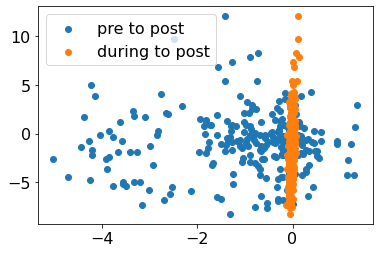

In [56]:
t = 2
plt.scatter(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t], label = 'pre to post')
print('pre to post:',stats.spearmanr(mean_diff_aucs[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.scatter(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t], label = 'during to post')
print('during to post:',stats.spearmanr(mean_diff_all_during[:,t],mean_diff_aucs_post[:,t],nan_policy='omit'))

plt.legend()



## THINK WHAT TO DO NEXT OR WHERE TO GO NEXT. - AFTER SEPT 23!!

In [48]:
tmedian = np.empty((268,))
tmedian[:] = np.nan
pmedian = np.empty_like(tmedian)
pmedian[:] = np.nan
median_diff = np.empty_like(tmedian)
median_diff[:] = np.nan
yes_no_sign = np.empty_like(tmedian)
yes_no_sign[:] = np.nan
for n in range(268):
    tmedian[n],pmedian[n] = \
        stats.ttest_rel(movie_tc_yes[:,n,int(t_TRs_ind[1])],
                        movie_tc_no[:,n,int(t_TRs_ind[1])],nan_policy='omit')
    yes_med = np.nanmedian(movie_tc_yes[:,n,int(t_TRs_ind[1])])
    no_med = np.nanmedian(movie_tc_no[:,n,int(t_TRs_ind[1])])
                           
    median_diff[n] = yes_med - no_med
    if abs(abs(yes_med) - abs(no_med)) > 1e-5:
        if abs(yes_med) > abs(no_med):
               yes_no_sign[n] = 1
        elif abs(yes_med) < abs(no_med):
                yes_no_sign[n] = -1
    else:
        yes_no_sign[n] = 0
        

- from the figure above (red = median social > nonsocial, color indicatesthe magnitude of differnce), it looks like most of the diffs at t approx.= 3secs is negative, i.e, social <nonsocial. Is this due to a dip in social or activation in random? let's compare absolute values at this point next.

- from the figure above (red = abs. median social > nonsocial, color indicates the magnitude of difference), it looks like a lot of the diffs at t approx.= 3secs is due to a higher magnitude for random but some are also due to social (red)

- red: mag social > nonsocial and vice versa

- previous and this figure together: most of the blue nodes are where there is a higher positive activation for billiards


In [192]:
np.where(ts_all[0][n] == int(t_TRs_ind[1])-1)[0]



array([], dtype=int64)

In [199]:
n=32

if ((len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)-1)[0])==0) and \
    (len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)+1)[0])==0)):
    print('in')

In [202]:
tmedian = np.empty((268,))
tmedian[:] = np.nan
pmedian = np.empty_like(tmedian)
pmedian[:] = np.nan
median_diff = np.empty_like(tmedian)
median_diff[:] = np.nan
yes_no_sign = np.empty_like(tmedian)
yes_no_sign[:] = np.nan
for n in range(268):
    tmedian[n],pmedian[n] = \
        stats.ttest_rel(movie_tc_yes[:,n,int(t_TRs_ind[1])],
                        movie_tc_no[:,n,int(t_TRs_ind[1])],nan_policy='omit')
    yes_med = np.nanmedian(movie_tc_yes[:,n,int(t_TRs_ind[1])])
    no_med = np.nanmedian(movie_tc_no[:,n,int(t_TRs_ind[1])])
                           
    median_diff[n] = yes_med - no_med
    if abs(abs(yes_med) - abs(no_med)) > 1e-5:
        if abs(yes_med) > abs(no_med):
               yes_no_sign[n] = 1
        elif abs(yes_med) < abs(no_med):
                yes_no_sign[n] = -1
    else:
        yes_no_sign[n] = 0

#consistentsy test:

for n in np.where(pmedian <.05)[0]:
    if ((len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)-1)[0])==0) and \
        (len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)+1)[0])==0)):
        pmedian[n] =np.nan
        tmedian[n] = np.nan
        
print(np.where(pmedian<.05))

tdiv_med = np.empty((268,))
tdiv_med[:] = np.nan
sign_diff = np.empty((268,))
sign_diff[:] = np.nan
ct = 1
for n in np.where(pmedian<.05)[0]:
    TRs = np.arange(1, max(t_TRs_ind))
    TRs = TRs[::-1]
    #print(TRs)
    supra_thresh_ct = 0
    for t in TRs:
        t = int(t)
        _, pval = stats.ttest_rel(movie_tc_yes[:,n,t],
                        movie_tc_no[:,n,t],nan_policy='omit')
        #print(n,t,pval)
        sign_diff = 1 if np.sign(np.nanmedian(movie_tc_yes[:,n,t]-movie_tc_no[:,n,t])) == \
        np.sign(np.nanmedian(movie_tc_yes[:,n,int(min(t_TRs_ind))]-movie_tc_no[:,n,int(min(t_TRs_ind))])) \
        else -1
        #print(t,pval,sign_diff)
        if (pval >= .05) | (sign_diff==-1):
            supra_thresh_ct += 1
        if supra_thresh_ct == ct:
            tdiv_med[n] = t+ct
            break
    
        
tdiv_med -= 3
tdiv_med

(array([  8,  12,  20,  22,  23,  24,  25,  26,  32,  33,  34,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  50,  51,  53,  56,  62,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  78,  79,  80,  81,  86,
        96,  99, 104, 110, 111, 113, 115, 121, 125, 136, 137, 142, 154,
       157, 158, 159, 161, 162, 164, 167, 169, 171, 172, 173, 174, 179,
       180, 182, 191, 199, 204, 205, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 217, 222, 224, 225, 235, 237, 240, 241, 245, 246, 249,
       251, 252, 253, 256, 259]),)


array([nan, nan, nan, nan, nan, nan, nan, nan,  5., nan, nan, nan,  5.,
       nan, nan, nan, nan, nan, nan, nan,  2., nan,  3.,  3.,  5.,  5.,
        2., nan, nan, nan, nan, nan,  2.,  5.,  4., nan,  5.,  4.,  5.,
        4.,  4.,  5., nan,  5.,  4.,  2., nan, nan, nan, nan,  1.,  2.,
       nan,  1., nan, nan,  5., nan, nan, nan, nan, nan,  5., nan,  2.,
        2.,  2.,  4.,  3., nan,  1.,  4.,  5.,  3., nan, nan, nan, nan,
        4.,  4.,  3.,  4., nan, nan, nan, nan,  4., nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  5., nan, nan,  5., nan, nan, nan, nan,
        3., nan, nan, nan, nan, nan,  3.,  4., nan,  5., nan,  5., nan,
       nan, nan, nan, nan,  5., nan, nan, nan,  5., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  2.,  5., nan, nan, nan, nan,  2.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  5., nan,
       nan,  5.,  3.,  4., nan,  2.,  4., nan,  3., nan, nan,  3., nan,
        5., nan,  4.,  5.,  4.,  4., nan, nan, nan, nan,  3.,  3

- here we can see that although several nodes show Yes> No in the end, there is often a yes-to-no flip (e.g. yes>no at t=28, but no>yes at t=10). To identify these and other diffs, next analyses:

1. identify accumulators, deciders etc. using all movies' data
2. use these labels to split nodes
3. also split nodes where activity flips from no>yes to yes>no

# Extra code

In [ ]:
n=14
tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]
auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
mean_difference = np.nanmean(auc1-auc2)
_,pval = stats.ttest_rel(auc1,auc2)

# not sure what this was for exactly..

# Extra code

In [ ]:
# plotting brainmap
#plot mean diffs at the earliest divergence point signed,thresholded
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
nComps = 4
mean_diff_all_during = np.empty((268,3))
mean_diff_all_during[:] = np.nan
nodes_all = []
for compType,lbl in enumerate(['COAXBILL','RAND','ALLMATCHED']):
    p = np.empty((268,))
    p[:] = np.nan
    meandiff_decpt = np.zeros((268,))
    if compType ==0:
        tc1 = tcs_trial_z[:,:,tr0_ind+tr_dec,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,tr0_ind+tr_dec, movie_ind_no]
        
        mean_diff_decpt = np.nanmean(tc1-tc2,axis =0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')
        
    elif compType==1:
        tc1 = tcs_run_z[subs1,:,tr0_ind+tr_dec,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,tr0_ind+tr_dec,movie_ind_same]

        mean_diff_decpt = np.nanmean(tc1,axis=0)-np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)

    elif compType==2:
        tc1 = tcs_trial_resh_yes_matched[:,:,tr0_ind+tr_dec]
        tc2 = tcs_trial_resh_no_matched[ :,:,tr0_ind+tr_dec]
        mean_diff_decpt = np.nanmean(tc1,axis=0) - np.nanmean(tc2,axis=0)
        for n in range(268):
            _,p[n] = stats.ttest_rel(tc1[:,n],tc2[:,n],nan_policy='omit')
    
    _,p = fdr_correction(p,.05)


    nodes = np.where(p<.05)[0] 
    print(lbl,': ', len(nodes),'nodes')
    nodes_all.append(nodes)
    mean_diff_all_during[:,compType] = mean_diff_decpt
    mean_diff_decpt1 = np.zeros((268,))
    mean_diff_decpt1[p<.05] = mean_diff_decpt[p<.05]
    img = roi_to_brain(pd.Series(mean_diff_decpt1), mask_x)
    txt = f"yes-no,TR={tr_dec},{lbl}_thr"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    
    img = roi_to_brain(pd.Series(mean_diff_decpt), mask_x)
    txt = f"yes-no,TR={tr_dec},{lbl}_unthr"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    #img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

    img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))
    

In [ ]:
plt.figure(1,figsize=(10,5)) # coaxbill vs. rand
plt.subplot(1,2,1)
plt.scatter(mean_diff_all_during[:,0],mean_diff_all_during[:,1],color='grey',marker='.')
plt.scatter(mean_diff_all_during[nodes_coaxbill_rand_all,0],mean_diff_all_during[nodes_coaxbill_rand_all,1],marker = 'o',facecolors = 'none', edgecolors ='g')
print(stats.spearmanr(mean_diff_all_during[:,0],mean_diff_all_during[:,1]))
plt.title('coax-bill VS. RANDOM MECH')
ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
m, b = np.polyfit(mean_diff_all_during[:,0],mean_diff_all_during[:,1], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

plt.xlabel('mean difference coax-bill')
plt.ylabel('mean difference RAND')

plt.subplot(1,2,2) # coaxbill vs. all matched
plt.scatter(mean_diff_all_during[:,0],mean_diff_all_during[:,2],color='grey',marker='.')
plt.scatter(mean_diff_all_during[nodes_coaxbill_rand_all,0],mean_diff_all_during[nodes_coaxbill_rand_all,2],marker = 'o',facecolors = 'none', edgecolors ='g')
print(stats.spearmanr(mean_diff_all_during[:,0],mean_diff_all_during[:,2]))
ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()
plt.title('coax-bill VS. all matched')
plt.xlabel('mean difference coax-bill')
plt.ylabel('mean difference all matched\nyes-no')
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
m, b = np.polyfit(mean_diff_all_during[:,0],mean_diff_all_during[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

plt.tight_layout()

In [ ]:
# plotting brainmap
#plot mean diffs at the earliest divergence point unsigned

movies_list = [2,3]
mean_diff_same_during = np.empty((268,len(movies_list)))
mean_diff_same_during[:] = np.nan

for i,m in enumerate(movies_list):
    print('movie: ' + str(vidnames[m]))
    subs1 = np.where(responses[:,m] == 1)[0]
    subs2 = np.where(responses[:,m] == 0)[0]
    p = np.empty((268,))
    p[:] = np.nan
    tc1 = tcs_run_z[subs1,:,tr0_ind+tr_dec,m]
    tc2 = tcs_run_z[subs2,:,tr0_ind+tr_dec,m]

    mean_diff_decpt = np.nanmean(tc1,axis=0)-np.nanmean(tc2,axis=0)
    for n in range(268):
        _,p[n] = stats.ttest_ind(tc1[:,n],tc2[:,n],nan_policy='omit',equal_var=False)
    
    nodes = np.where(p<=.05)[0]
    print('signodes:',len(nodes))

    mean_diff_same_during[:,i] = mean_diff_decpt
    #mean_diff_same_during[p>.05,i] = np.nan
    img = roi_to_brain(pd.Series(mean_diff_same_during[:,i]), mask_x)
    txt = f"sameMovie{str.upper(vidnames[m][:4])}_Yes-no,TR={tr_dec}"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    #img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                     display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

    img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))


plt.figure(1,figsize=(5,5))
'''plt.subplot(1,2,1)
plt.scatter(mean_diff_all_during[:,1],mean_diff_same_during[:,0],color='grey',marker='.')
plt.scatter(mean_diff_all_during[nodes_coaxbill_rand_all,1],mean_diff_same_during[nodes_coaxbill_rand_all,0],marker = 'o',facecolors = 'none', edgecolors ='g')
print(stats.spearmanr(mean_diff_all_during[:,1],mean_diff_same_during[:,0]))
plt.title('RANDOM MECH vs. DRIFTING')
ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
plt.xlabel('mean difference RAND')
plt.ylabel('mean difference DRIF')


plt.subplot(1,2,2)''' # best to exclude driftng because it showed weird results in the GLM analyses too and we excluded it there
plt.scatter(mean_diff_all_during[:,1],mean_diff_same_during[:,1],color='grey',marker='.')
plt.scatter(mean_diff_all_during[nodes_coaxbill_rand_all,1],mean_diff_same_during[nodes_coaxbill_rand_all,1],marker = 'o',facecolors = 'none', edgecolors ='g')
print(stats.spearmanr(mean_diff_all_during[:,1],mean_diff_same_during[:,1]))
plt.title('RANDOM MECH v. FISHING')
plt.xlabel('mean difference RAND')
plt.ylabel('mean difference FISH')
plt.vlines(0,ymin,ymax, color = 'grey')
plt.hlines(0,xmin,xmax, color = 'grey')
plt.tight_layout()

In [ ]:
# pre-decision AUC

mean_diff_all = []
mean_diff_aucs = np.empty((268,3))
mean_diff_aucs [:] = np.nan
nodes_all_pre = []
#tr_dec =5

for compType,lbl in enumerate(['coaxbill','rand','allmatched']):
    
    for n in range(268):
        if compType == 0:
            if n==0:
                p = np.empty((268,))
                p[:] = np.nan
            tc1 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_yes]
            tc2 = tcs_trial_z[:,n,:int(tr0_ind+tr_dec),movie_ind_no]

        elif compType == 1:
            tc1 = tcs_run_z[subs1,n,:int(tr0_ind+tr_dec),movie_ind_same]
            tc2 = tcs_run_z[subs2,n,:int(tr0_ind+tr_dec),movie_ind_same]
            
        
        elif compType == 2:
            tc1 = tcs_trial_resh_yes_matched[:,n,:int(tr0_ind+tr_dec)]
            tc2 = tcs_trial_resh_no_matched[:,n,:int(tr0_ind+tr_dec)]
        

        auc1 = np.array([np.trapz(tc1[s,:]) for s in range(tc1.shape[0])])
        auc2 = np.array([np.trapz(tc2[s,:]) for s in range(tc2.shape[0])])
        if compType == 0:
            _,p[n] = stats.ttest_rel(auc1,auc2,nan_policy='omit')
            mean_diff_aucs[n,compType] = np.nanmean(auc1-auc2)
        else:
            _,p[n] = stats.ttest_ind(auc1,auc2,nan_policy='omit',equal_var=False)
            mean_diff_aucs[n,compType] = np.nanmean(auc1)-np.nanmean(auc2)
        
        #_,p = fdr_correction(p,.05)
    
    nodes = np.where(p<.05)[0] 
    print(lbl,': ', len(nodes),'nodes')
    nodes_all_pre.append(p<.05)
    mean_diff_aucs1 = np.zeros((268,))
    mean_diff_aucs1[p<.05] = mean_diff_aucs[p<.05,compType]
    img = roi_to_brain(pd.Series(mean_diff_aucs1), mask_x)
    txt = f"yes-no,0-{tr_dec}s,{lbl}_thr_pre"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

    
    img = roi_to_brain(pd.Series(mean_diff_aucs[:,compType]), mask_x)
    txt = f"yes-no,0-{tr_dec}s,{lbl}_unthr_pre"
    img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
    #img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                    display_mode='lyrz', plot_abs=False, black_bg=True,cmap = 'RdBu_r')

    img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))
        